In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import cv2
import os 
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image
import random
import matplotlib.image as mpimg
from imutils import paths
import sys
import operator

In [3]:
!pip install rich
!pip install hydra-core
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 14.3 MB/s 
     |████████████████████████████████| 51 kB 9.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 151 kB 14.3 MB/s 
     |████████████████████████████████| 117 kB 55.4 MB/s 
     |████████████████████████████████| 79 kB 8.6 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=e069a5af52a7148cbb319062f64cfbab2fe386045d07cb8eec324eb8654ed82a
  Stored in directory: /root/.cache/pip/wheels/8b/8d/53/2af8772d9aec614e3fc65e53d4a993ad73c61daa8bbd85a873
Successfully built antlr4-python3-runtime


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 706 kB 14.1 MB/s 
     |████████████████████████████████| 5.9 MB 70.9 MB/s 
     |████████████████████████████████| 419 kB 70.3 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.


In [4]:
sys.path.insert(0, "/content/drive/MyDrive/Github_Repos/historia_ml_handwritten_text_line_segmentation")
sys.path.insert(1, "/content/drive/MyDrive/Github_Repos/historia_ml_handwritten_text_line_segmentation/src/utils")

In [5]:
import pytorch_lightning as pl
from src.utils.display_image_from_path import img_show
from src.utils.display_image_from_array import img_show_from_arr
from src.utils.delete_border_lines import delete_border_lines
from src.utils.take_pixels_whose_neighbors_are_zero import next_neighbor_as_zero
from src.utils.get_row_heights import get_row_heights
from src.utils.get_col_widths import get_col_widths
from src.utils.erase_short_lines import erase_lines_with_small_width
from src.utils.erase_small_lines import erase_lines_with_small_height
from src.utils.find_image_page_type import find_image_page_type
from src.utils.create_row_patches_from_lines_y_coordinates import create_row_patches
from src.utils.get_unique_cols_from_row_patches import create_unique_patch_cols
from src.utils.create_row_patch_mapping import get_patch_map
from src.utils.create_bboxes import create_bbox_list
from src.utils.create_line_images_from_bbox import create_line_image_from_bbox
from src.utils.create_row_images_from_bbox_list import create_row_images
from src.utils.get_bboxes_from_mask import get_bboxes_from_mask
from src.utils.save_line_images import save_line_images
from src.utils.display_and_save_line_images import display_and_save_line_images

In [6]:
img_path = "/content/drive/MyDrive/Images/esad-71.png"
img = cv2.imread(img_path)
img_mask = cv2.imread("/content/drive/MyDrive/output/test_page_predicted_masks/esad-71_mask_307x307.png")

img_show_from_arr(img)
img_show_from_arr(img_mask)

Output hidden; open in https://colab.research.google.com to view.

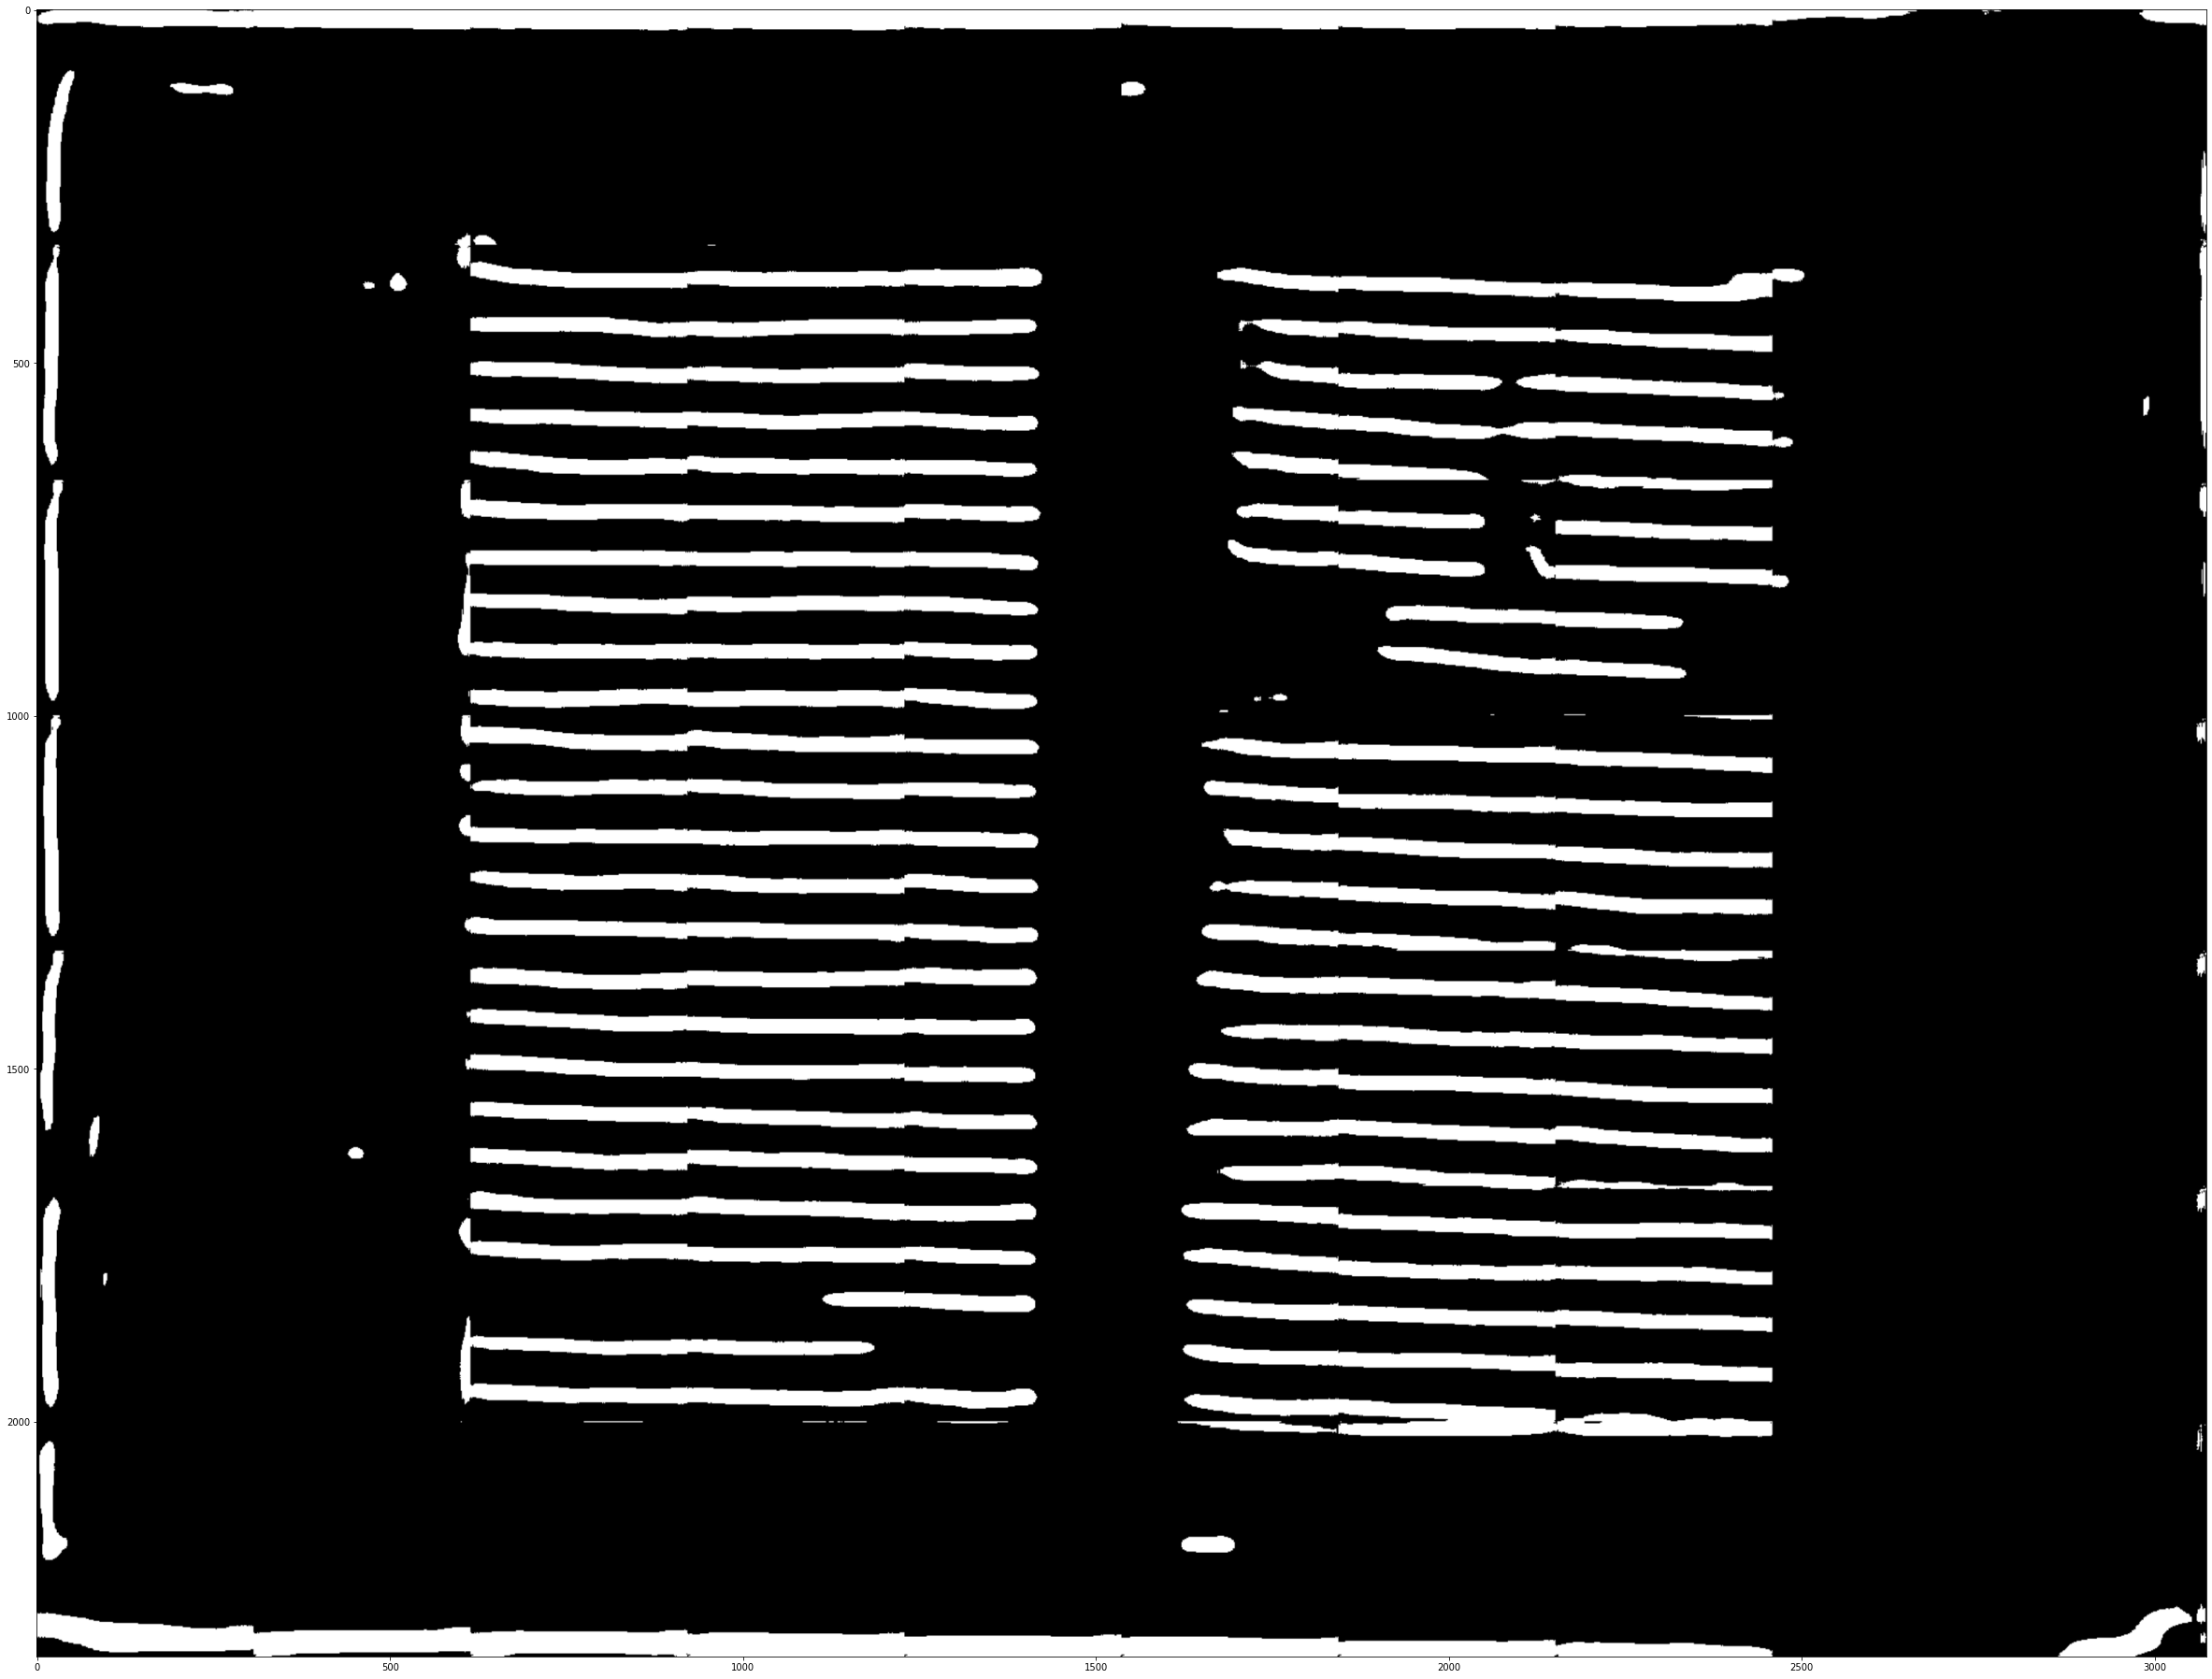

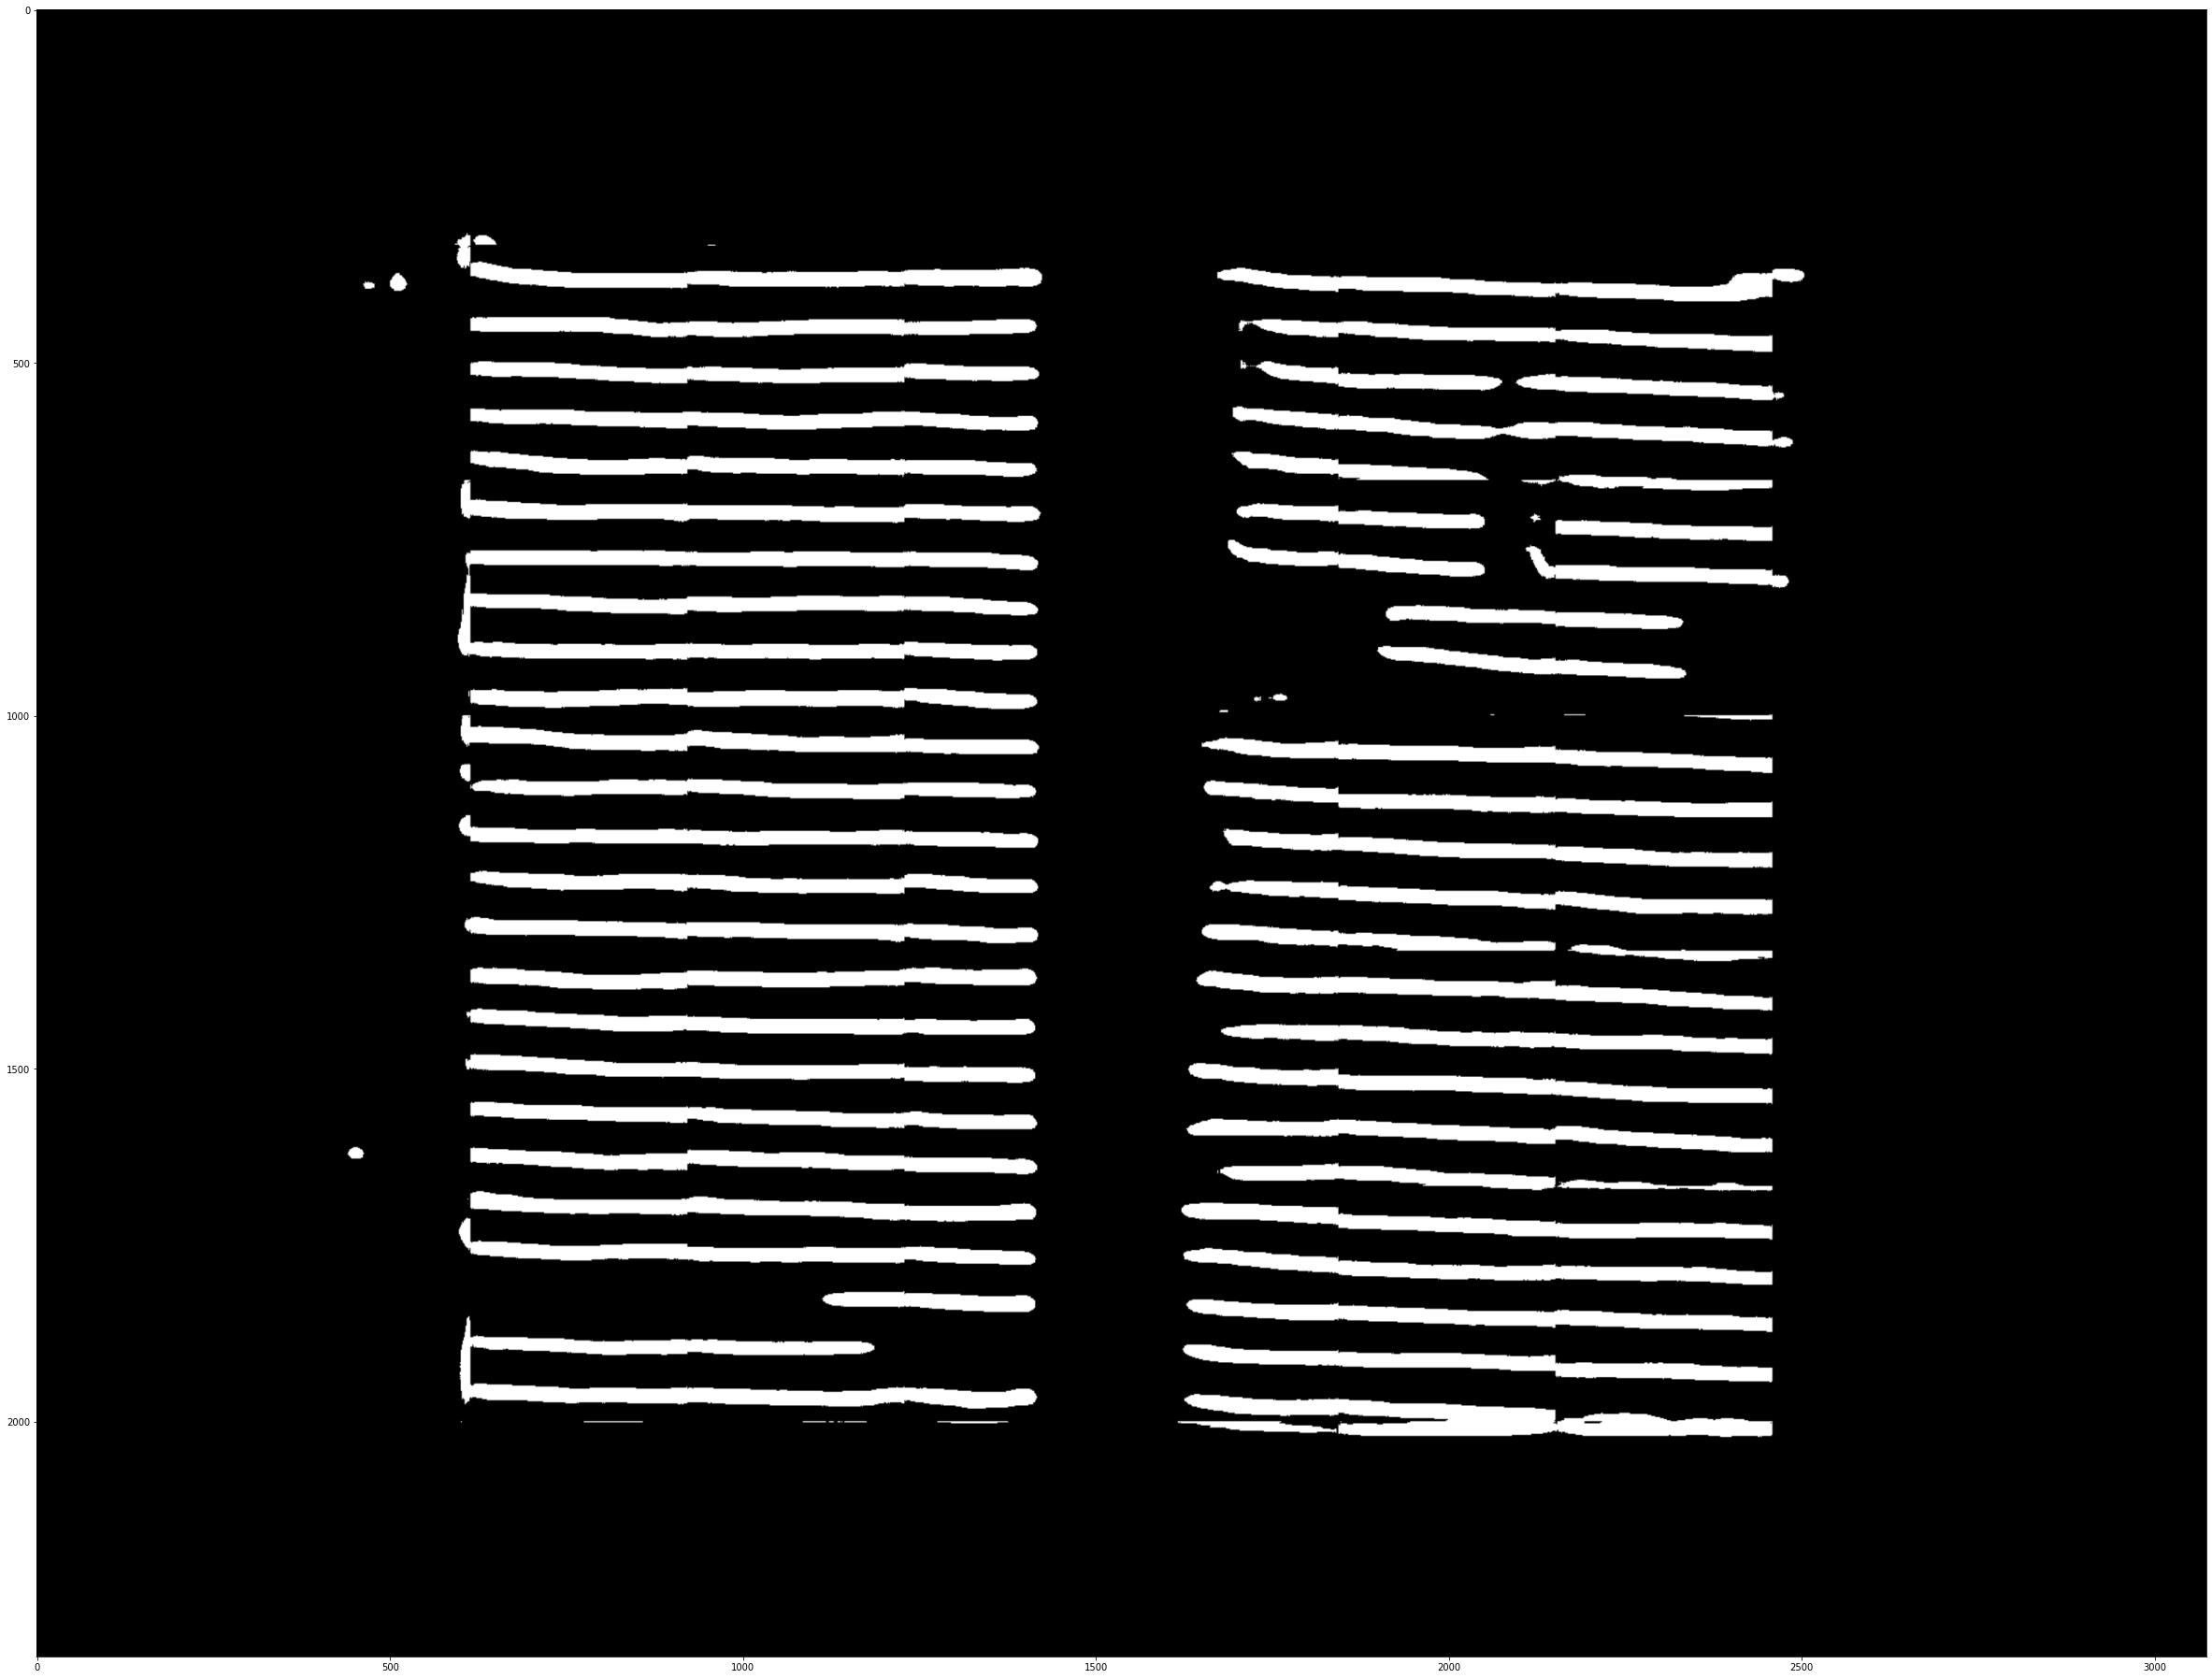

In [7]:
mask = img_mask.copy()
mask = delete_border_lines(mask=mask, x_ratio=0.05, y_ratio=0.1)
img_show_from_arr(img_mask)
img_show_from_arr(mask)

In [8]:
mask2 = mask.copy()

In [9]:
freq = []
h, w, d = mask.shape
for j in range(w):
  col_white_counter = 0
  for i in range(h):
    if mask[i][j][0] != 0:
      col_white_counter += 1
  freq.append(col_white_counter)

In [10]:
len(freq)

3073

In [11]:
freq[1300:1350]

[541,
 544,
 544,
 546,
 546,
 542,
 542,
 542,
 541,
 541,
 541,
 541,
 545,
 544,
 542,
 543,
 543,
 543,
 542,
 544,
 544,
 544,
 539,
 537,
 537,
 537,
 541,
 541,
 541,
 541,
 539,
 540,
 540,
 539,
 540,
 539,
 541,
 542,
 542,
 542,
 544,
 547,
 545,
 545,
 544,
 542,
 539,
 540,
 542,
 540]

In [12]:
freq_nz = []
for i in range(len(freq)):
  if freq[i] != 0:
    freq_nz.append(freq[i])
len(freq_nz)

1787

In [13]:
freq = np.array(freq)
mean_freq = np.mean(freq)

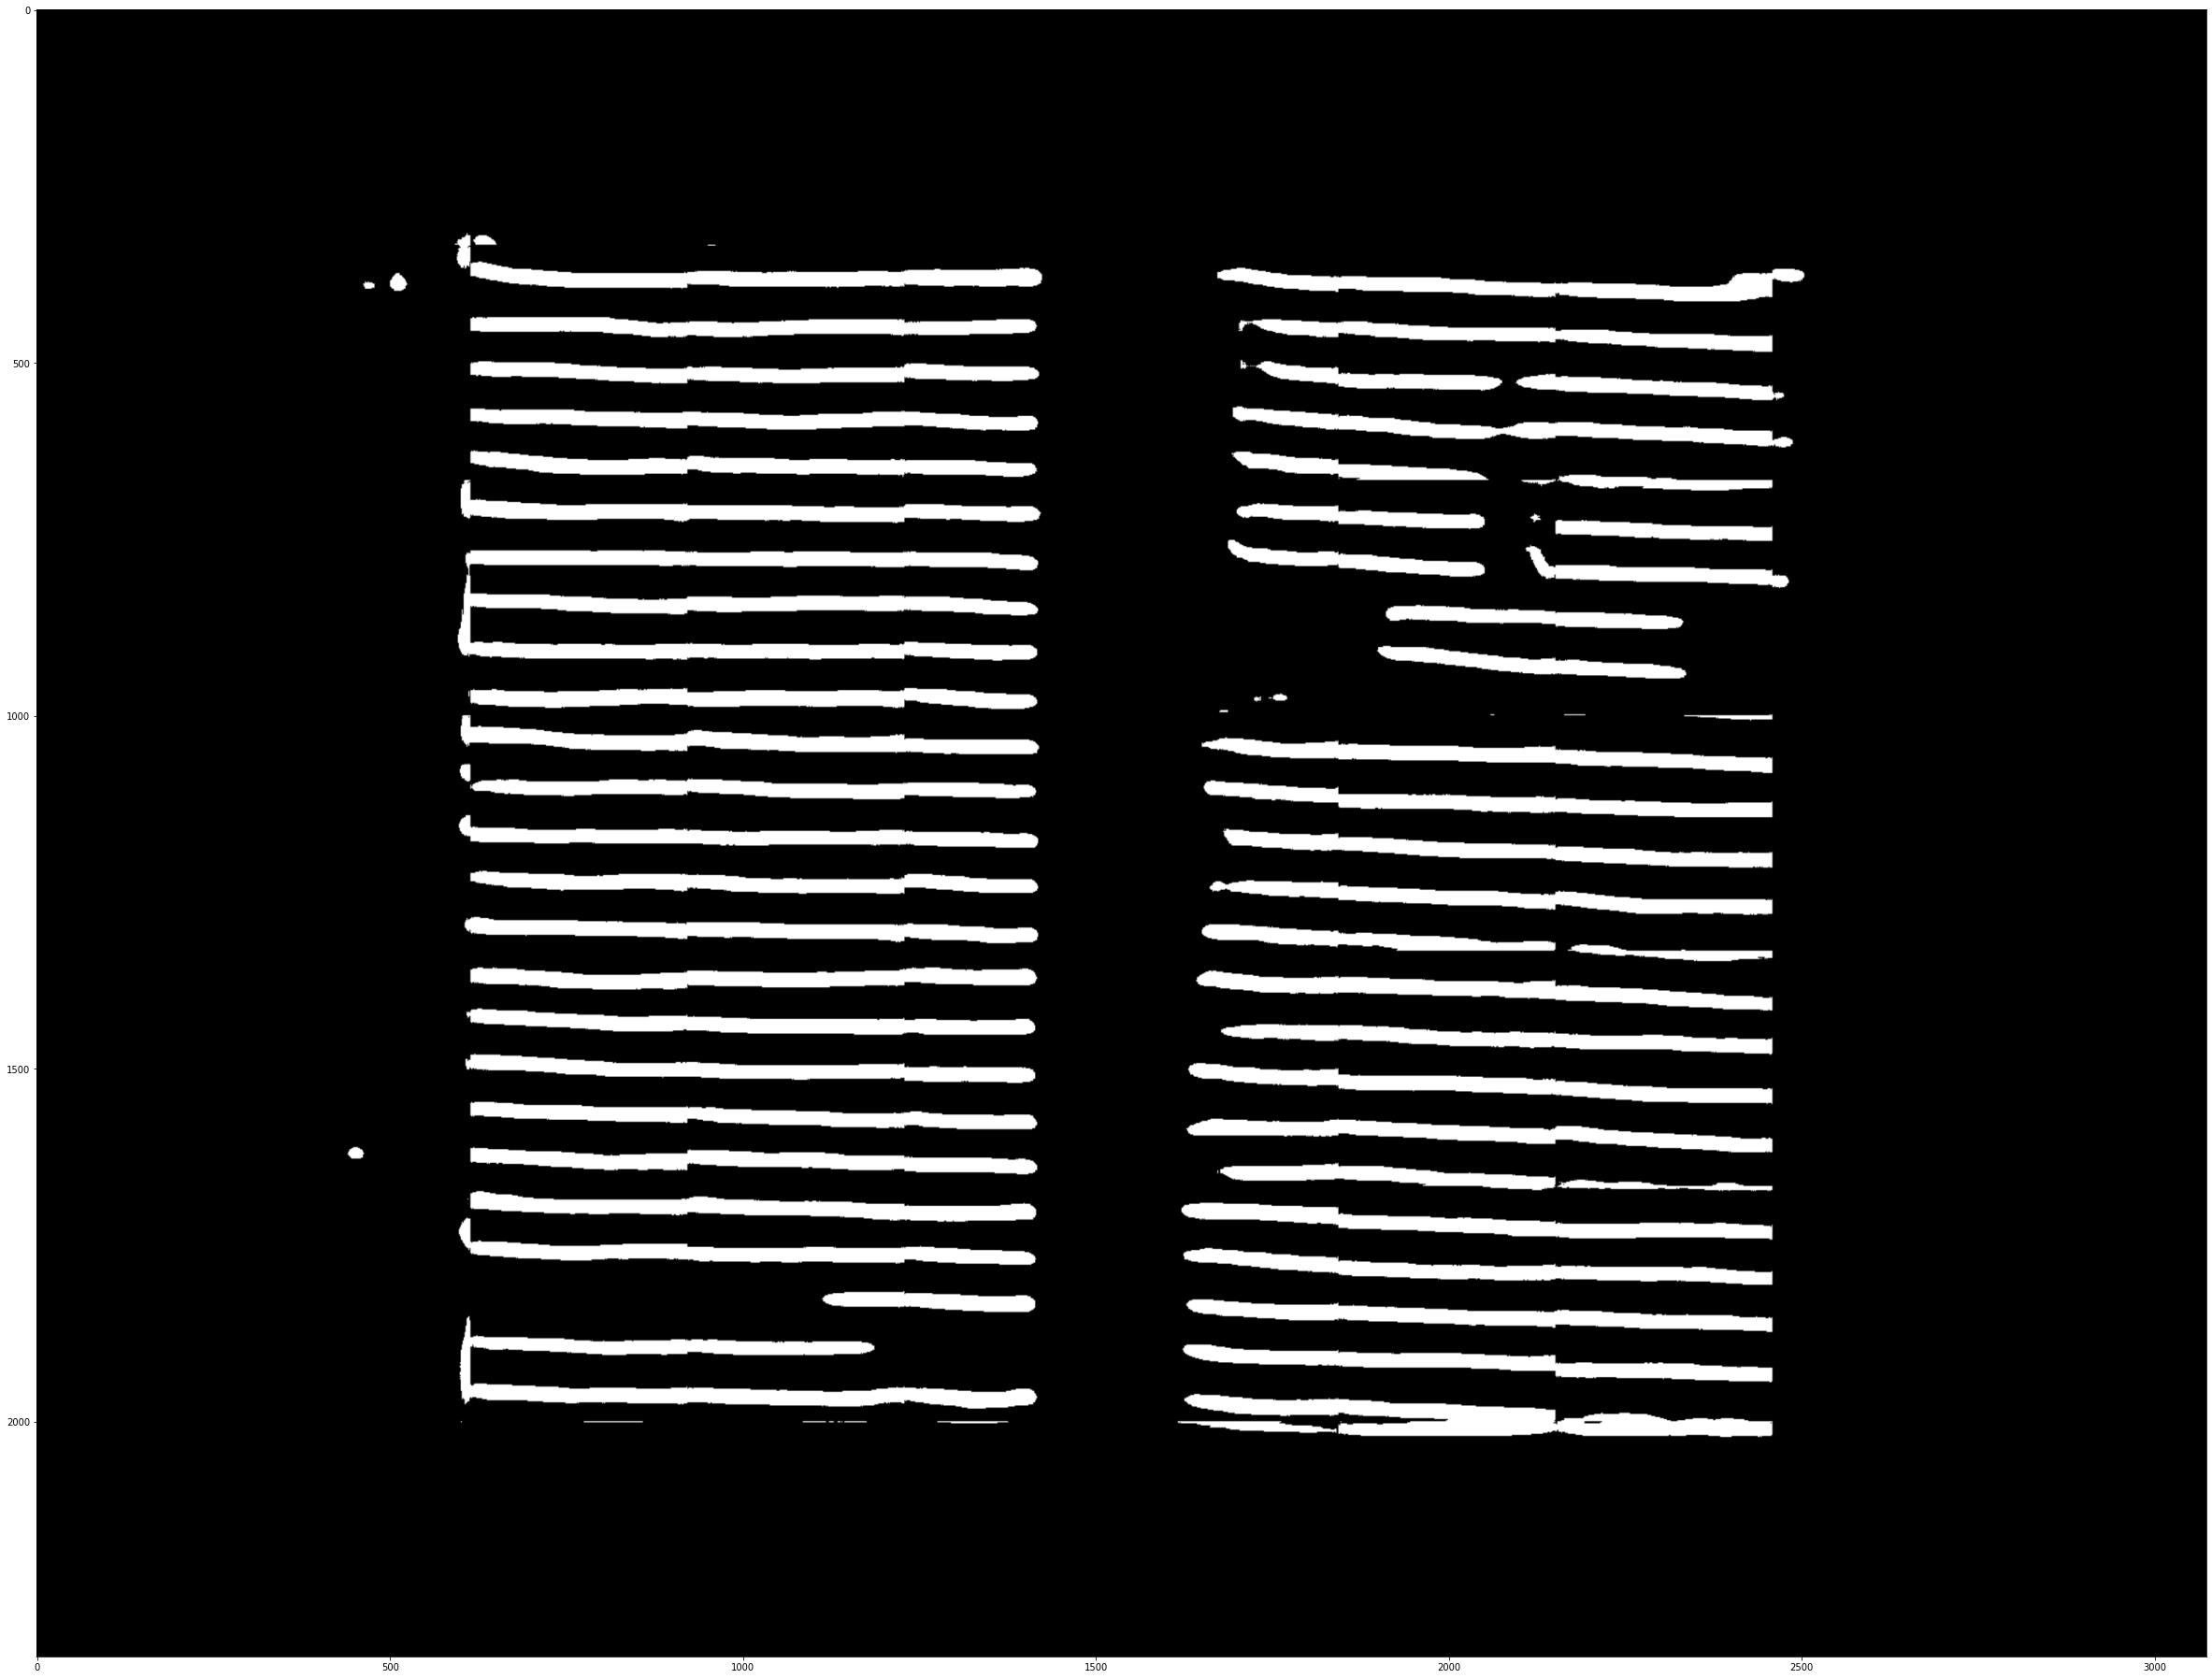

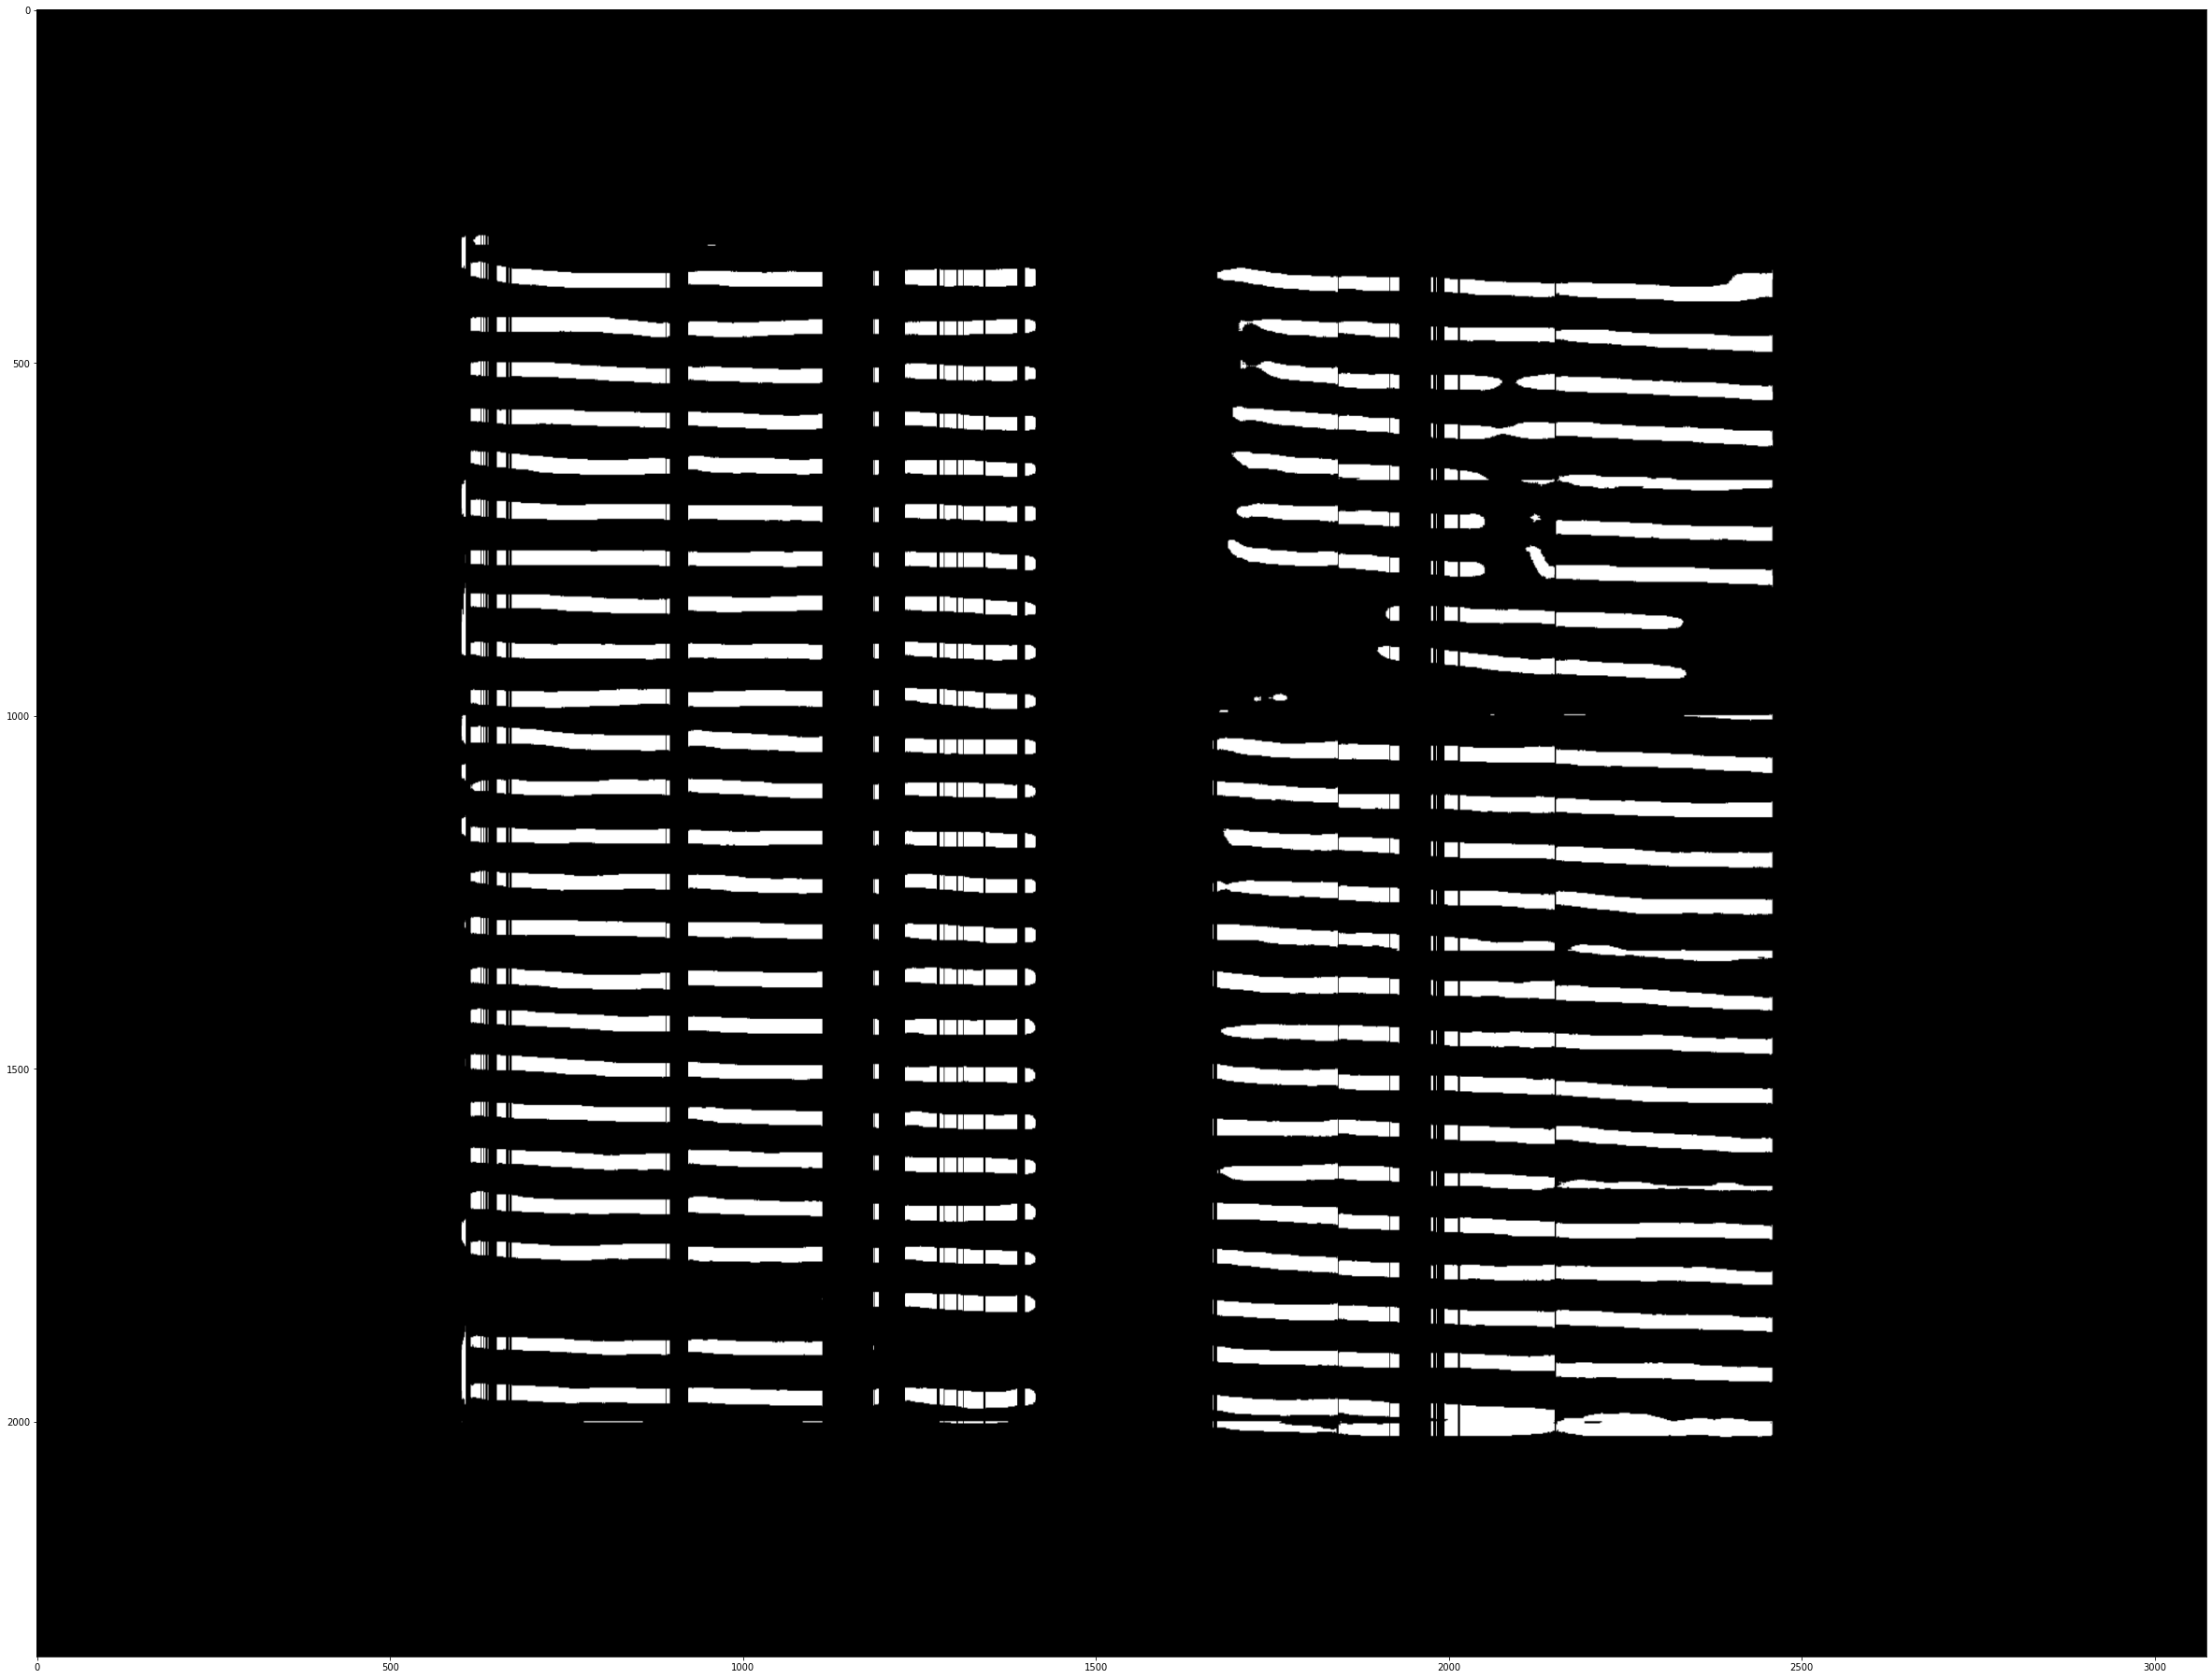

In [14]:
for i in range(len(freq)):
  if freq[i] < mean_freq or freq[i] > 2 * mean_freq:
    for j in range(h):
      mask2[j][i] = 0
img_show_from_arr(mask)
img_show_from_arr(mask2)

In [15]:
freq_x = []
h, w, d = mask.shape
for i in range(h):
  row_white_counter = 0
  for j in range(w):
    if mask[i][j][0] != 0:
      row_white_counter += 1
  freq_x.append(row_white_counter)

In [16]:
len(freq_x)

2333

In [17]:
freq_x_nz = []
for i in range(len(freq_x)):
  if freq_x[i] != 0:
    freq_x_nz.append(freq_x[i])
len(freq_x_nz)

1633

In [18]:
def preprocess_erasing(mask):
  freq_y = []
  h, w, d = mask.shape
  for j in range(w):
    counter = 0
    for i in range(h):
      if mask[i][j][0] != 0:
        counter += 1
    freq_y.append(counter)
  
  freq_ynz = []
  for i in range(len(freq_y)):
    if freq_y[i] != 0:
      freq_ynz.append(freq_y[i])

  mean_freq_y = np.mean(np.array(freq_ynz))
  for i in range(len(freq_y)):
    if freq_y[i] < mean_freq_y or freq_y[i] > 2 * mean_freq_y:
      for j in range(h):
        mask[j][i] = 0

  freq_x = []
  for i in range(h):
    counter = 0
    for j in range(w):
      if mask[i][j][0] != 0:
        counter += 1
    freq_x.append(counter)

  freq_xnz = []
  for i in range(len(freq_x)):
    if freq_x[i] != 0:
      freq_xnz.append(freq_x[i])

  mean_freq_x = np.mean(np.array(freq_xnz))

  for i in range(len(freq_x)):
    if freq_x[i] < 0.3 * mean_freq_x:
      for j in range(w):
        mask[i][j] = 0
    
  return mask


In [19]:
freq_x = np.array(freq_x)
mean_freq_x = np.mean(freq_x)

In [20]:
mean_freq_x

358.9219888555508

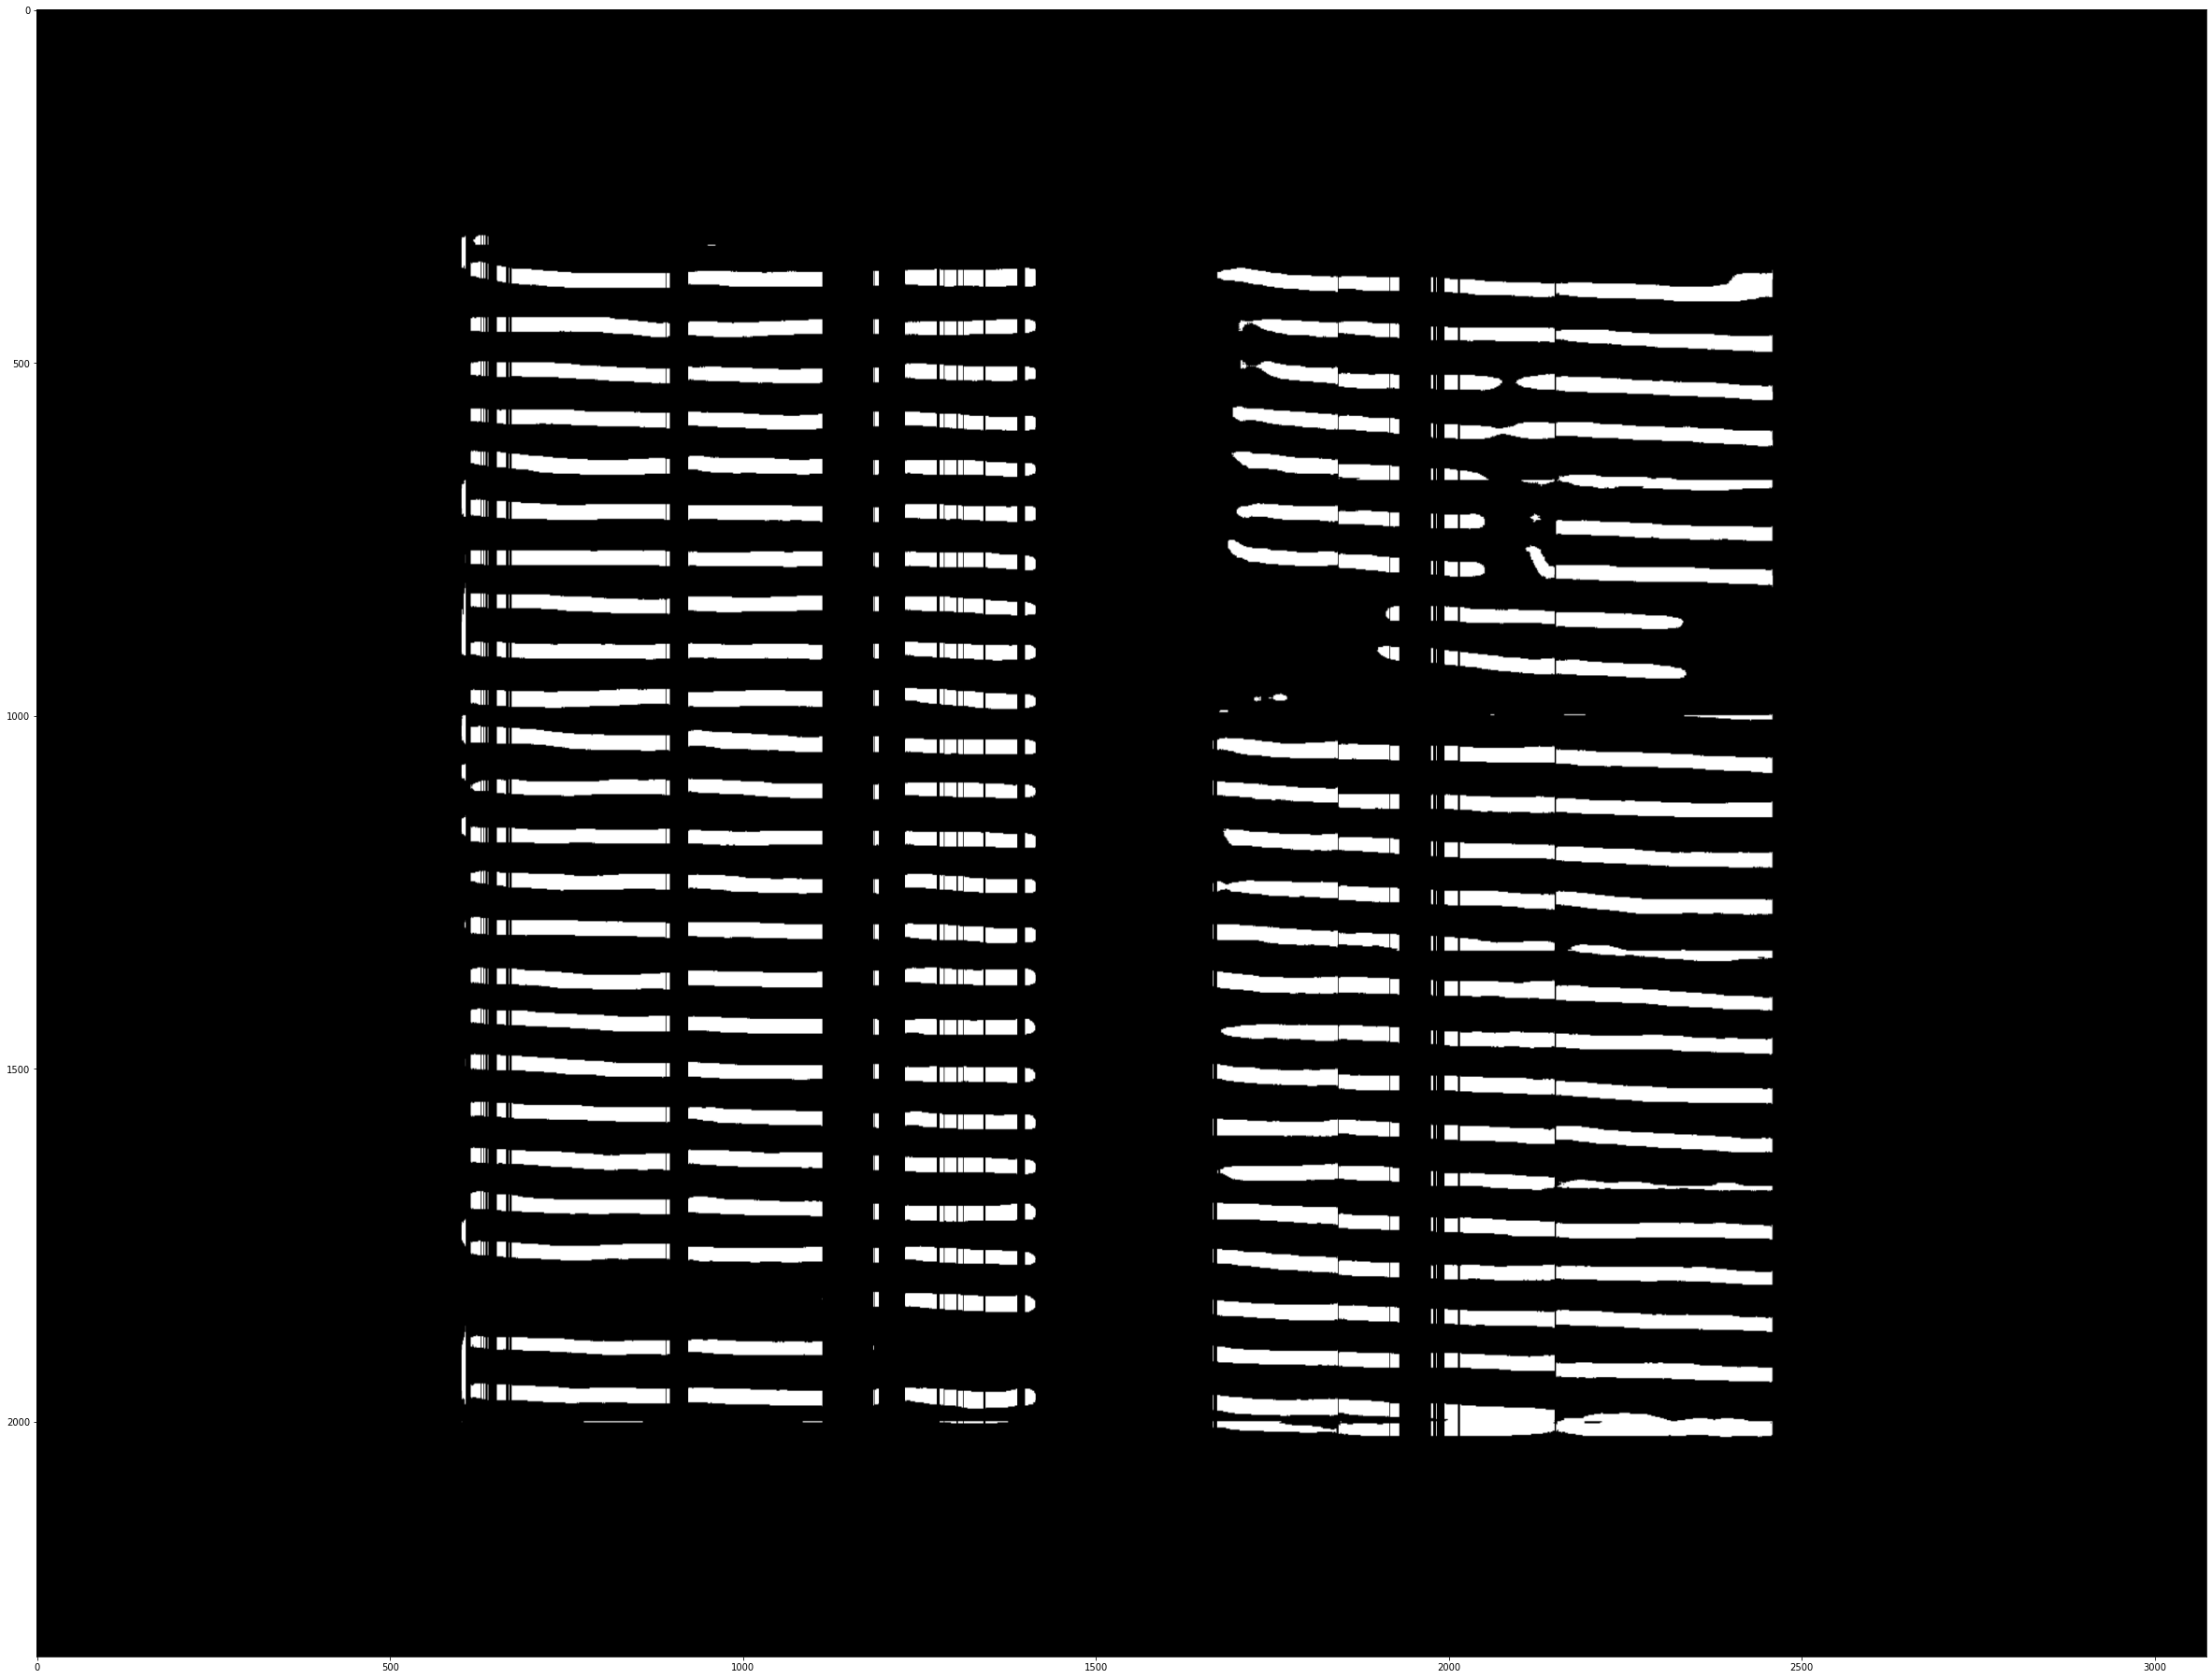

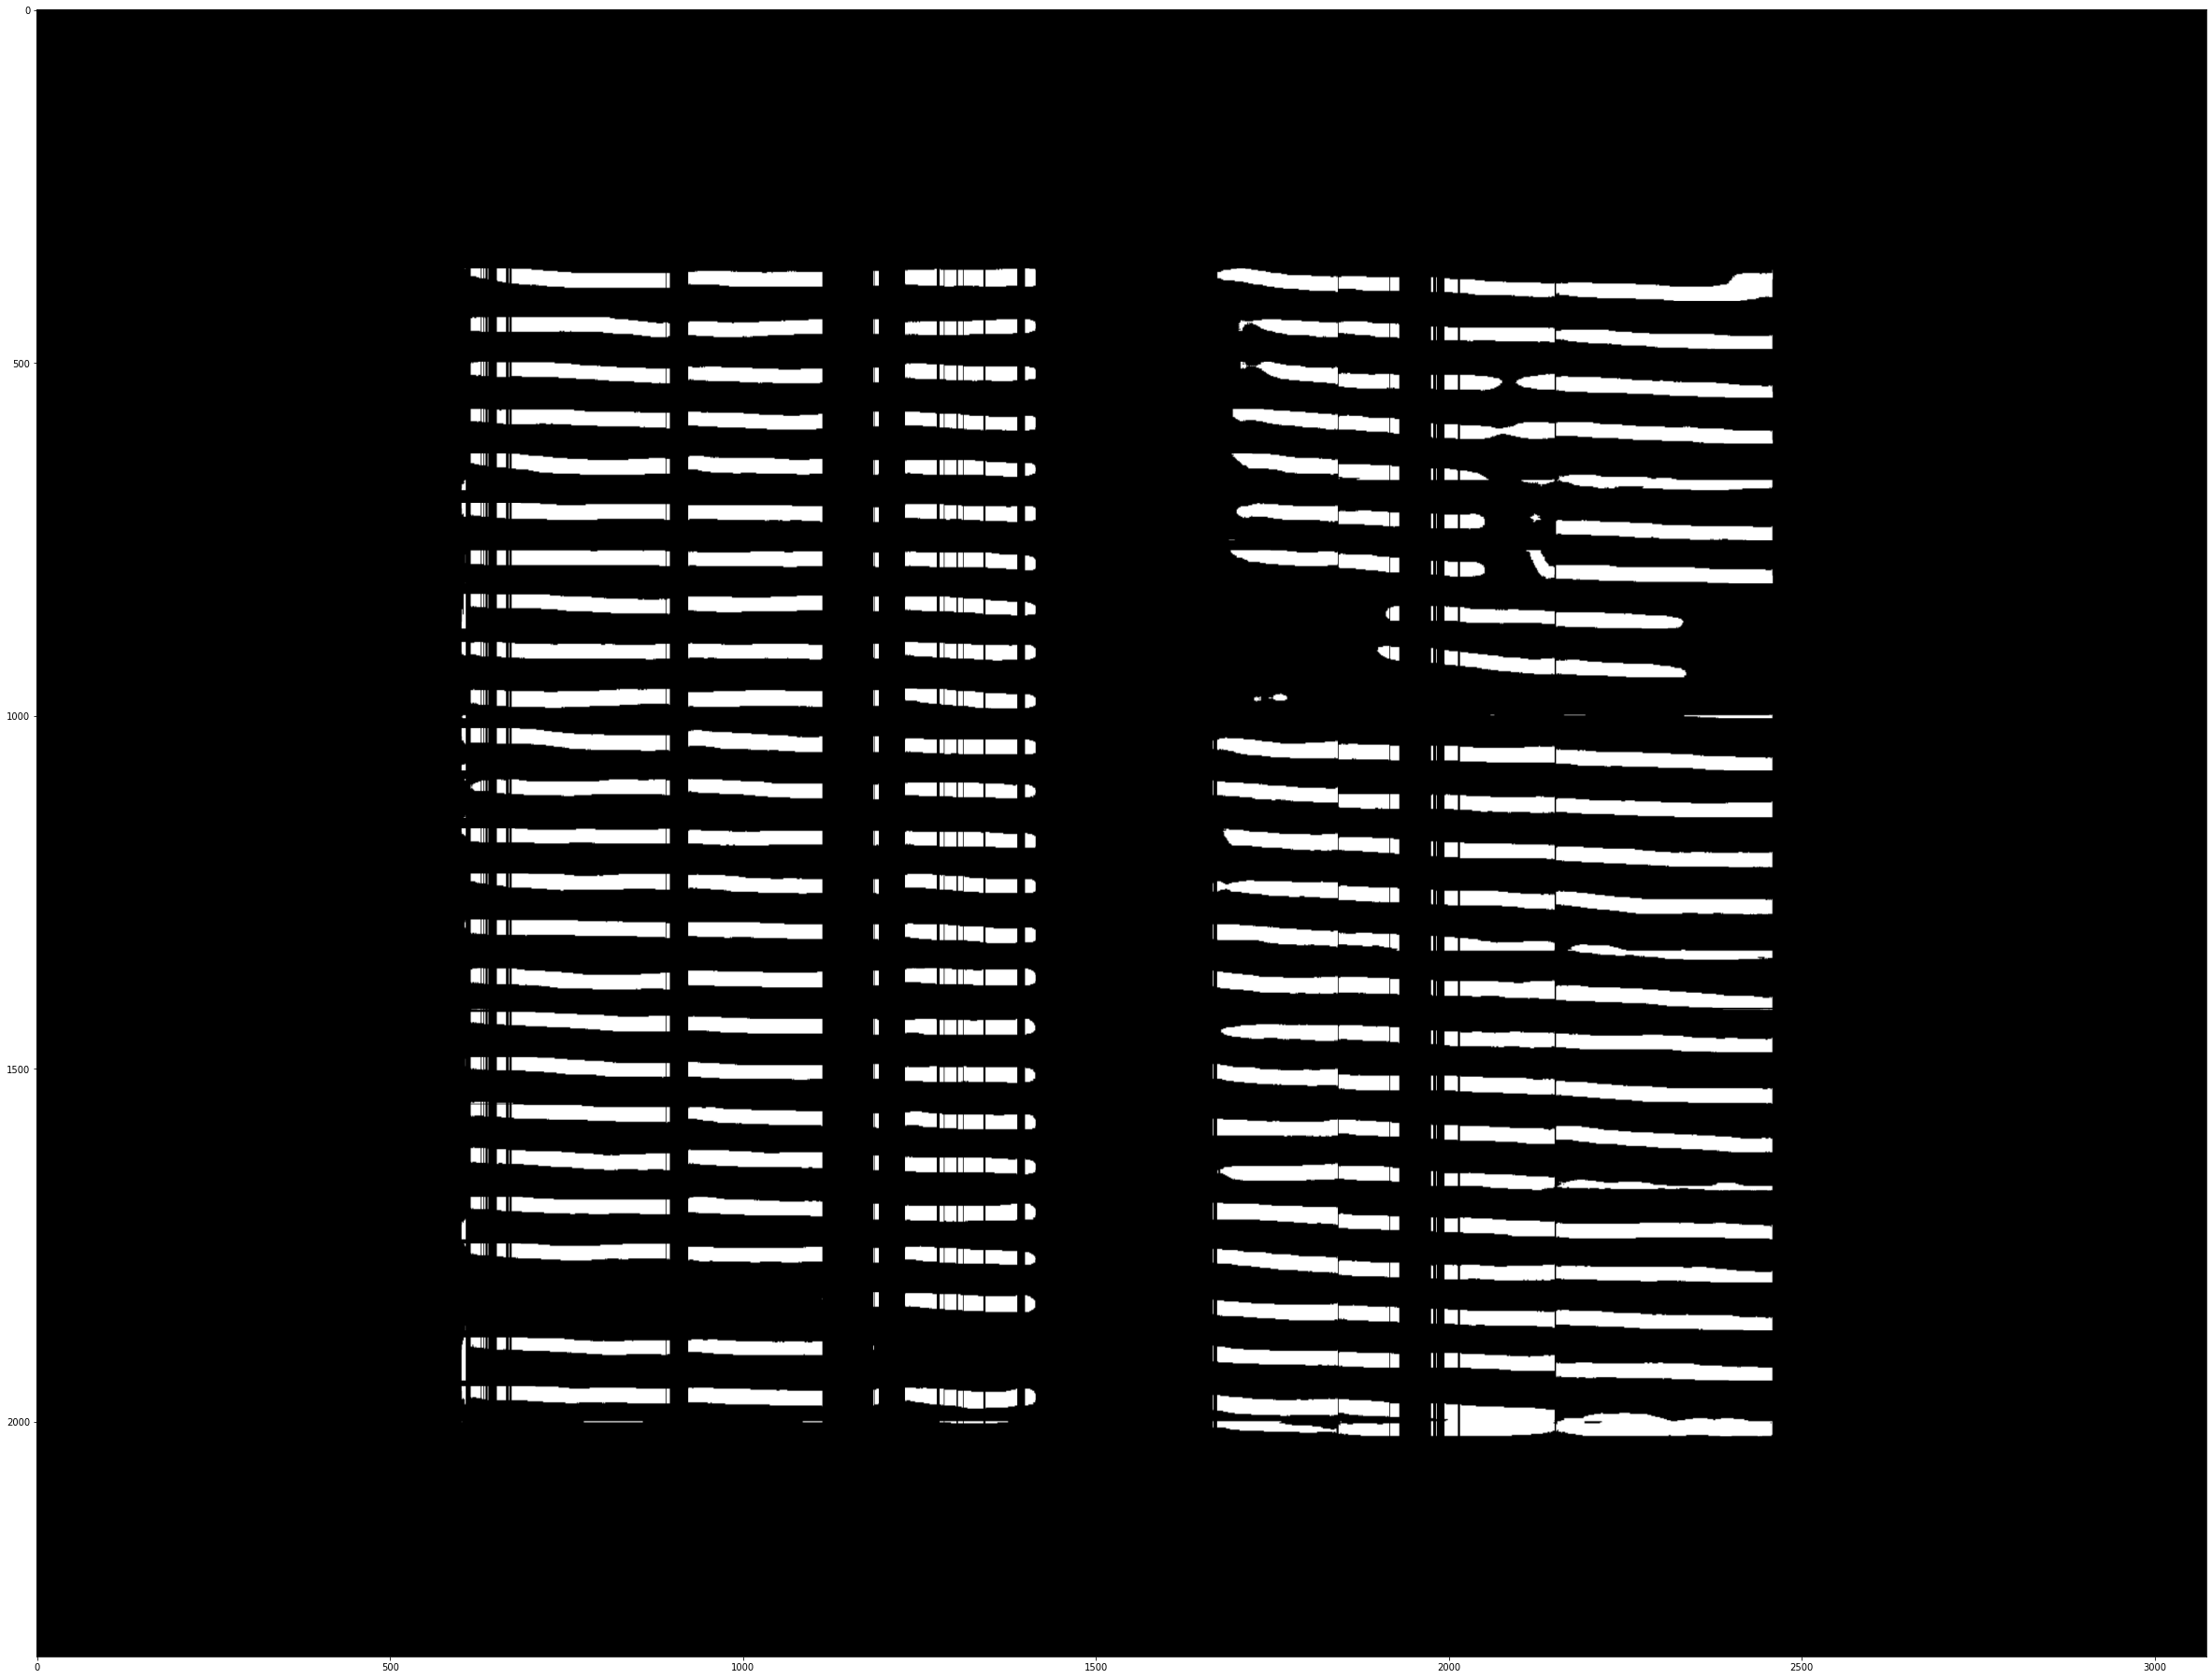

In [21]:
mask3 = mask2.copy()
for i in range(len(freq_x)):
  if freq_x[i] < 0.3 * mean_freq_x:
    for j in range(w):
      mask3[i][j] = 0
img_show_from_arr(mask2)
img_show_from_arr(mask3)

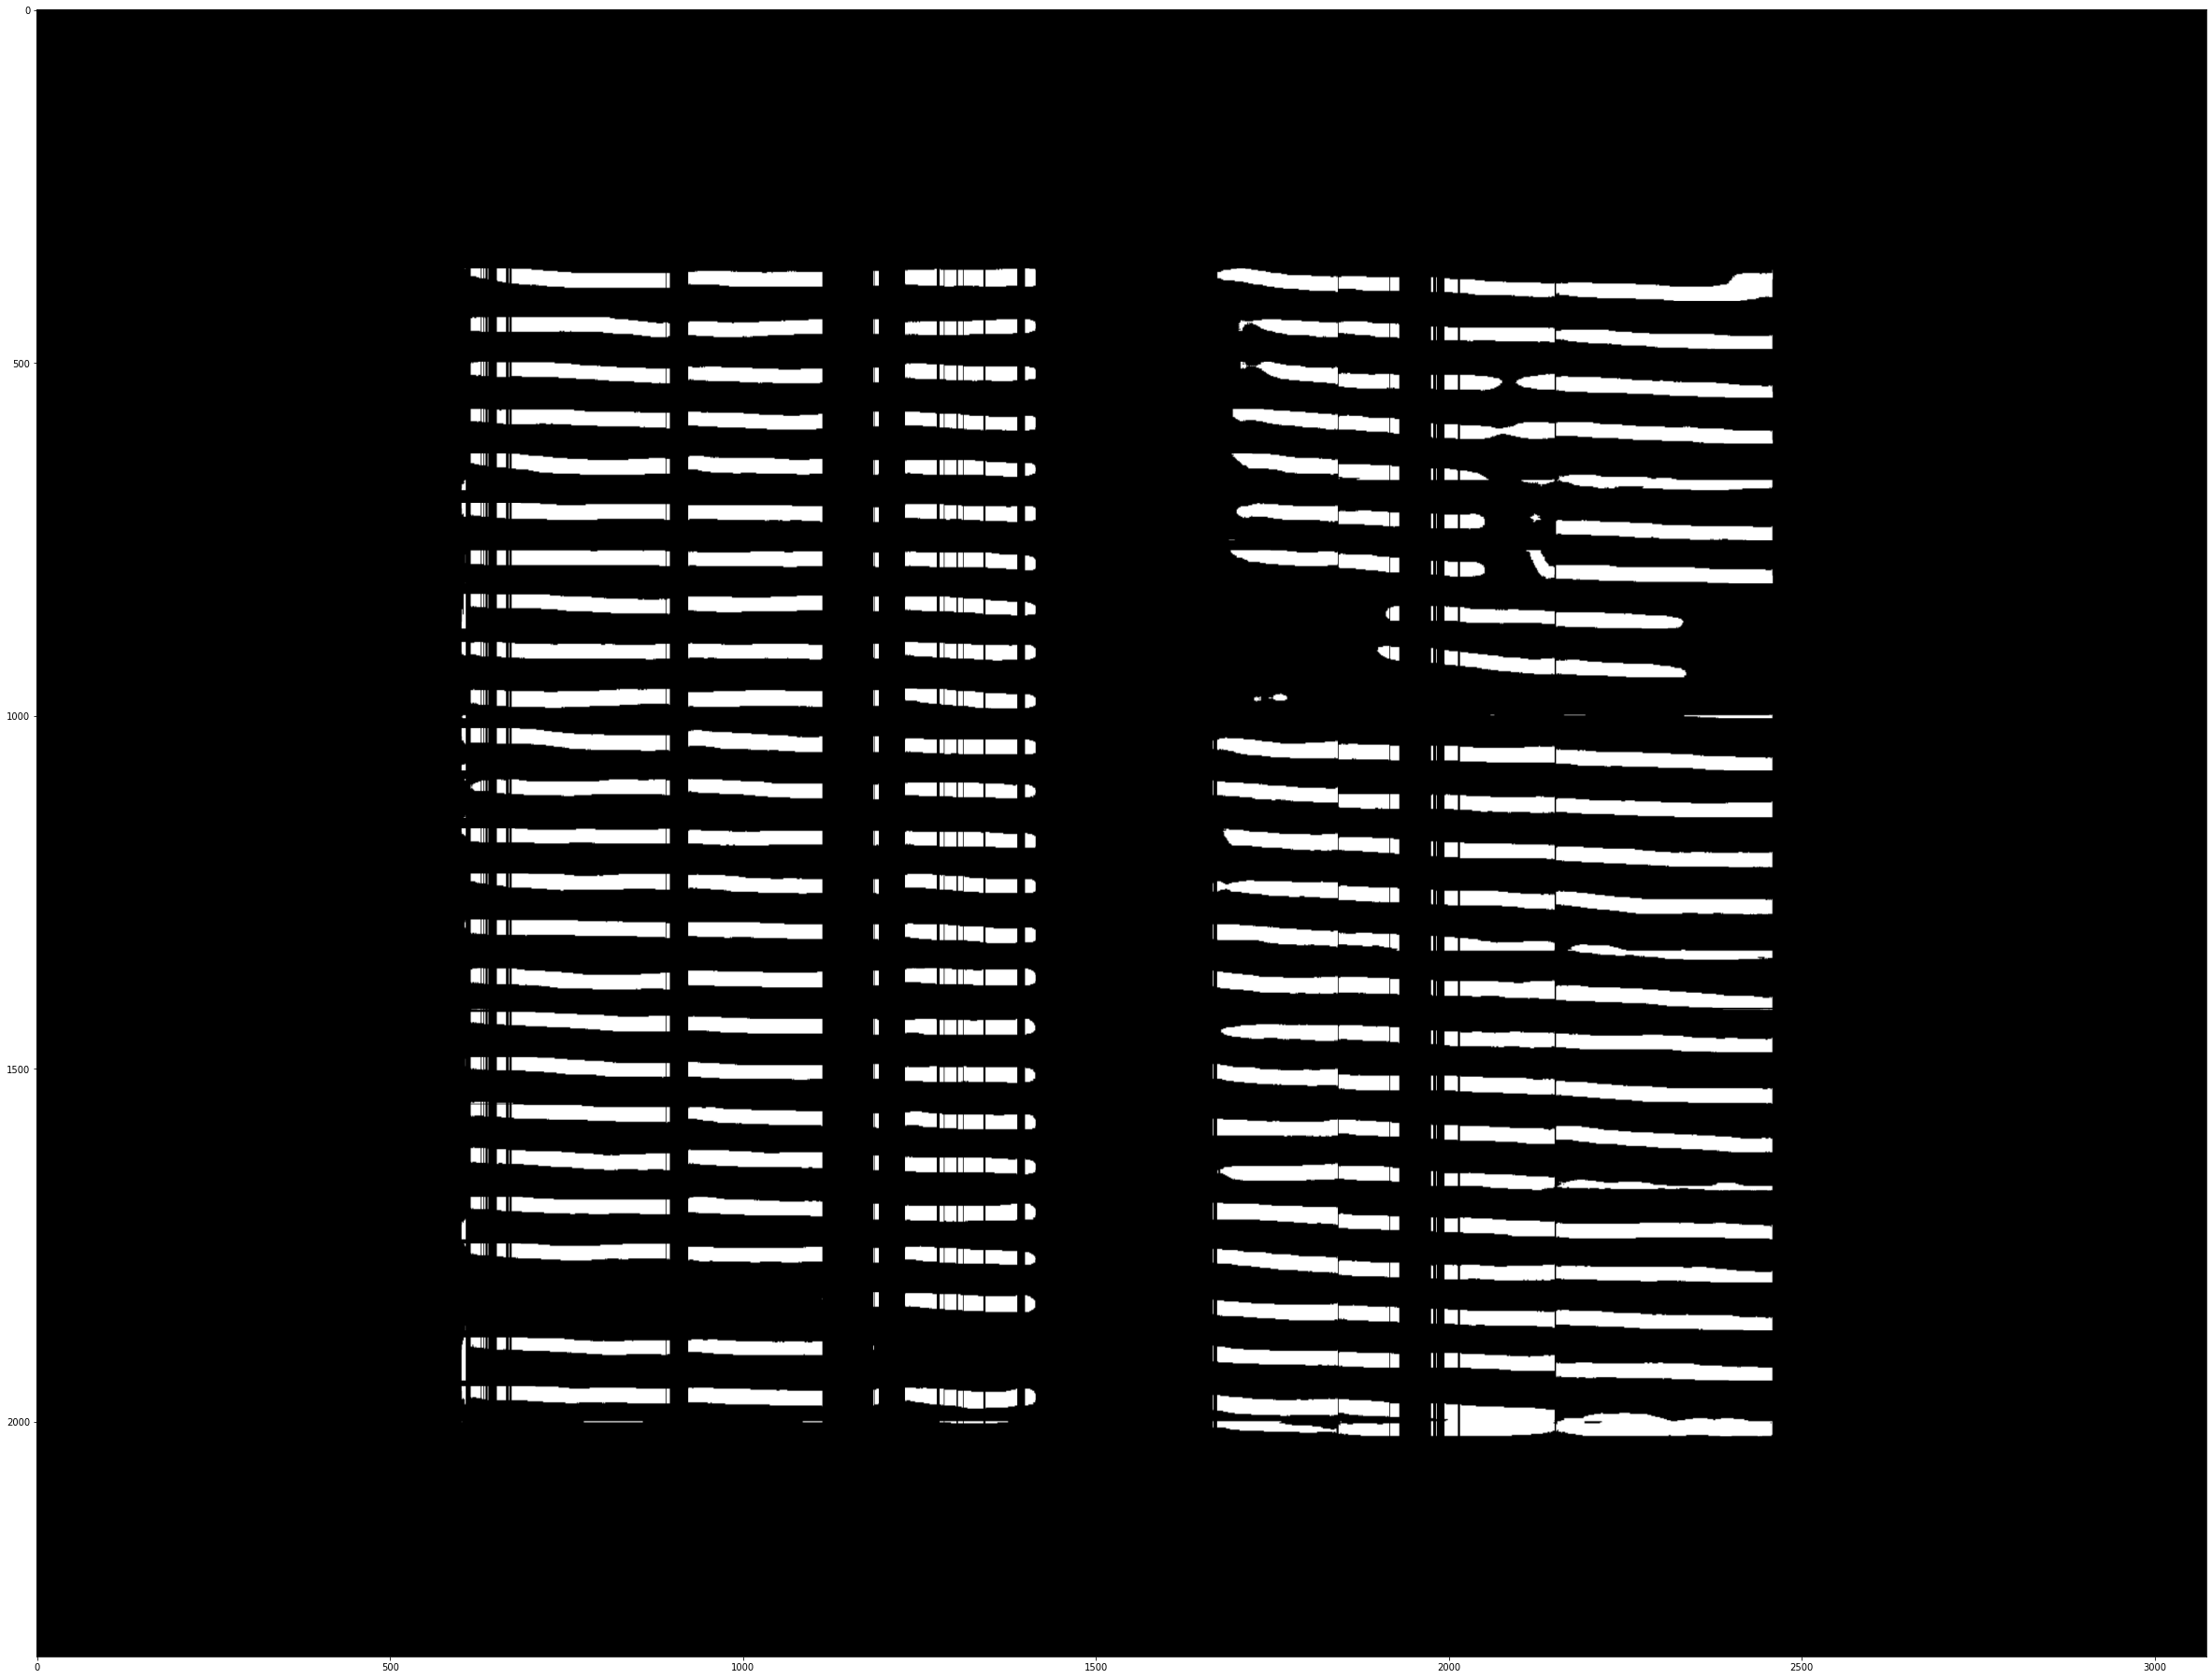

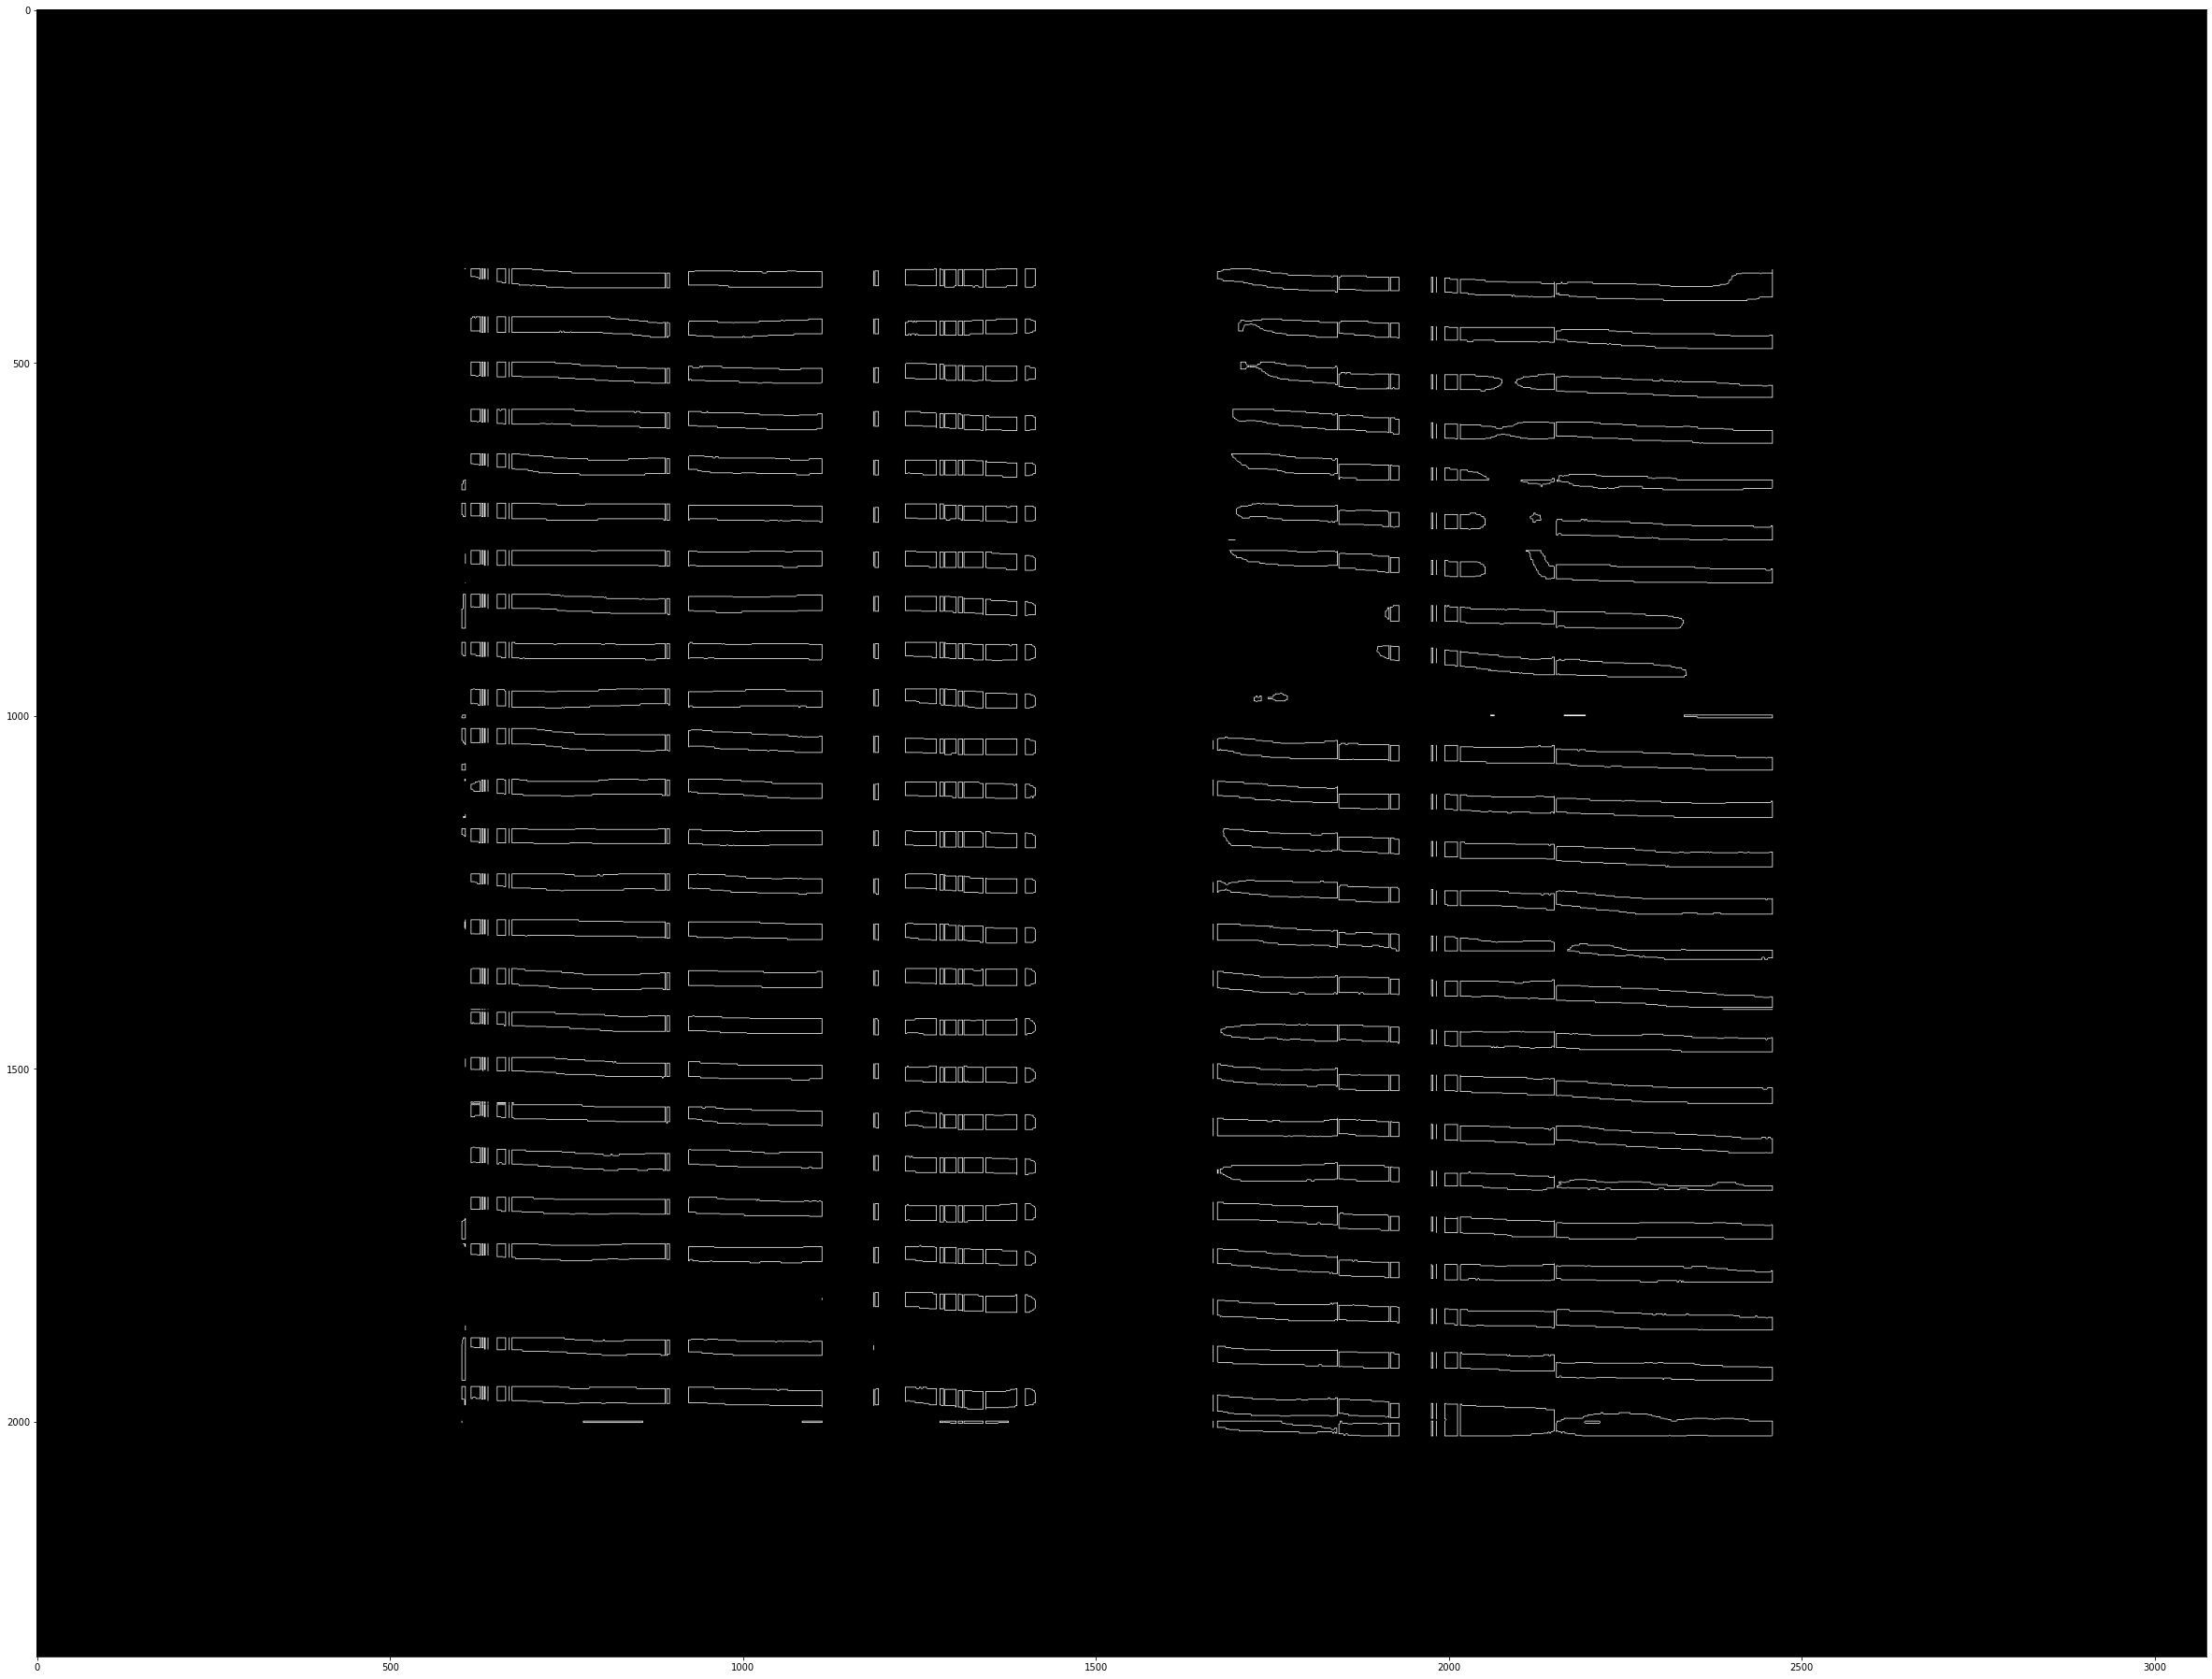

In [22]:
mask3_coords = next_neighbor_as_zero(mask3)
mask4 = np.zeros(mask3.shape)
for coord in mask3_coords:
  mask4[coord[0]][coord[1]][0] = 255
  mask4[coord[0]][coord[1]][1] = 255
  mask4[coord[0]][coord[1]][2] = 255
img_show_from_arr(mask3)
img_show_from_arr(mask4)

In [23]:
mask4_x_coords = [coord[1] for coord in mask3_coords]
len(mask4_x_coords)

88066

In [24]:
mask4_x_coords = np.array(mask4_x_coords)
mask4_unique_x_coords = np.unique(mask4_x_coords)
len(mask4_unique_x_coords)

1344

In [25]:
bbox_x_coords = []
bbox_x_coords.append(mask4_unique_x_coords[0])
for i in range(len(mask4_unique_x_coords)-1):
  if abs(mask4_unique_x_coords[i] - mask4_unique_x_coords[i+1]) > 2:
    bbox_x_coords.append(mask4_unique_x_coords[i])
    bbox_x_coords.append(mask4_unique_x_coords[i+1])
bbox_x_coords.append(mask4_unique_x_coords[-1])
bbox_x_coords

[602,
 607,
 615,
 635,
 639,
 639,
 652,
 664,
 669,
 669,
 673,
 896,
 923,
 1112,
 1185,
 1192,
 1230,
 1274,
 1279,
 1302,
 1305,
 1340,
 1344,
 1388,
 1400,
 1414,
 1666,
 1666,
 1672,
 1929,
 1975,
 1977,
 1982,
 1982,
 1994,
 2012,
 2016,
 2149,
 2152,
 2458]

In [26]:
bbox_x_coords = np.array(bbox_x_coords)
bbox_x_coords = np.unique(bbox_x_coords)
bbox_x_coords

array([ 602,  607,  615,  635,  639,  652,  664,  669,  673,  896,  923,
       1112, 1185, 1192, 1230, 1274, 1279, 1302, 1305, 1340, 1344, 1388,
       1400, 1414, 1666, 1672, 1929, 1975, 1977, 1982, 1994, 2012, 2016,
       2149, 2152, 2458])

In [27]:
bbox_x1x2 = [(bbox_x_coords[i], bbox_x_coords[i+1]) for i in range(0, len(bbox_x_coords)-1, 2)]
bbox_x1x2

[(602, 607),
 (615, 635),
 (639, 652),
 (664, 669),
 (673, 896),
 (923, 1112),
 (1185, 1192),
 (1230, 1274),
 (1279, 1302),
 (1305, 1340),
 (1344, 1388),
 (1400, 1414),
 (1666, 1672),
 (1929, 1975),
 (1977, 1982),
 (1994, 2012),
 (2016, 2149),
 (2152, 2458)]

In [28]:
mask4_col_widths = get_col_widths(bbox_x1x2)
mask4_col_widths

[5, 20, 13, 5, 223, 189, 7, 44, 23, 35, 44, 14, 6, 46, 5, 18, 133, 306]

In [29]:
col_width_limit = np.mean(mask4_col_widths) * 0.7
col_width_limit

44.17777777777778

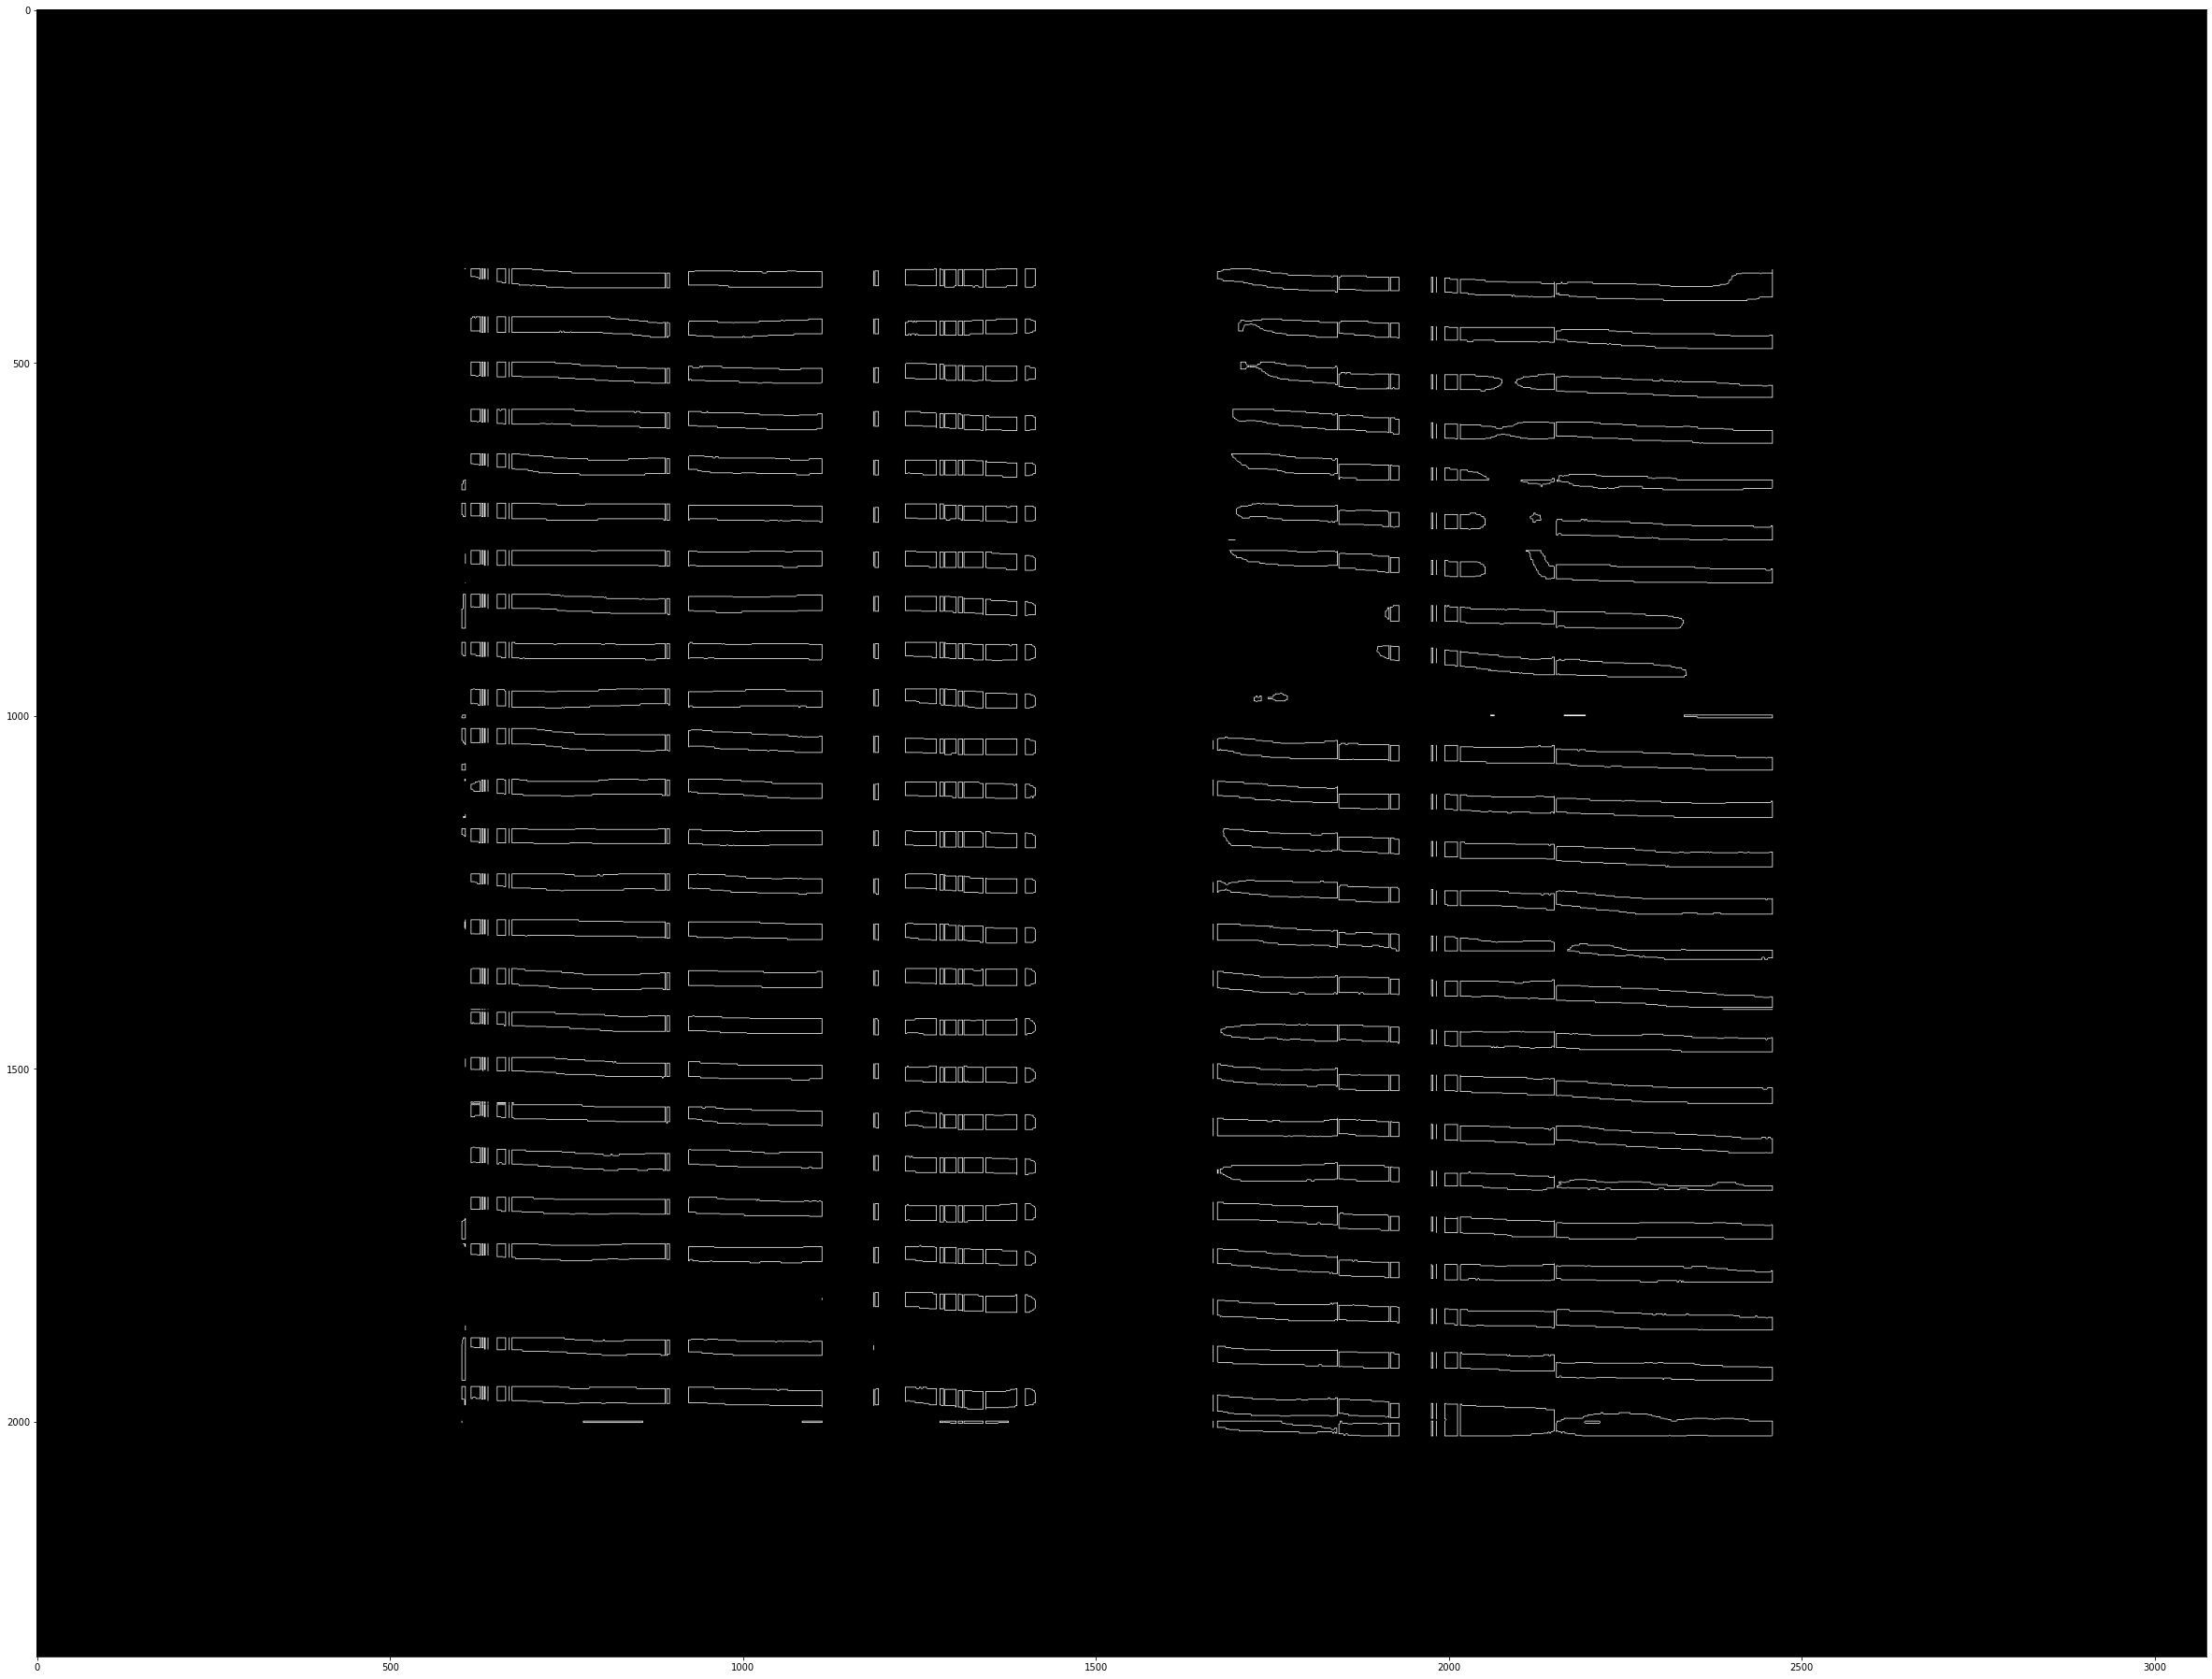

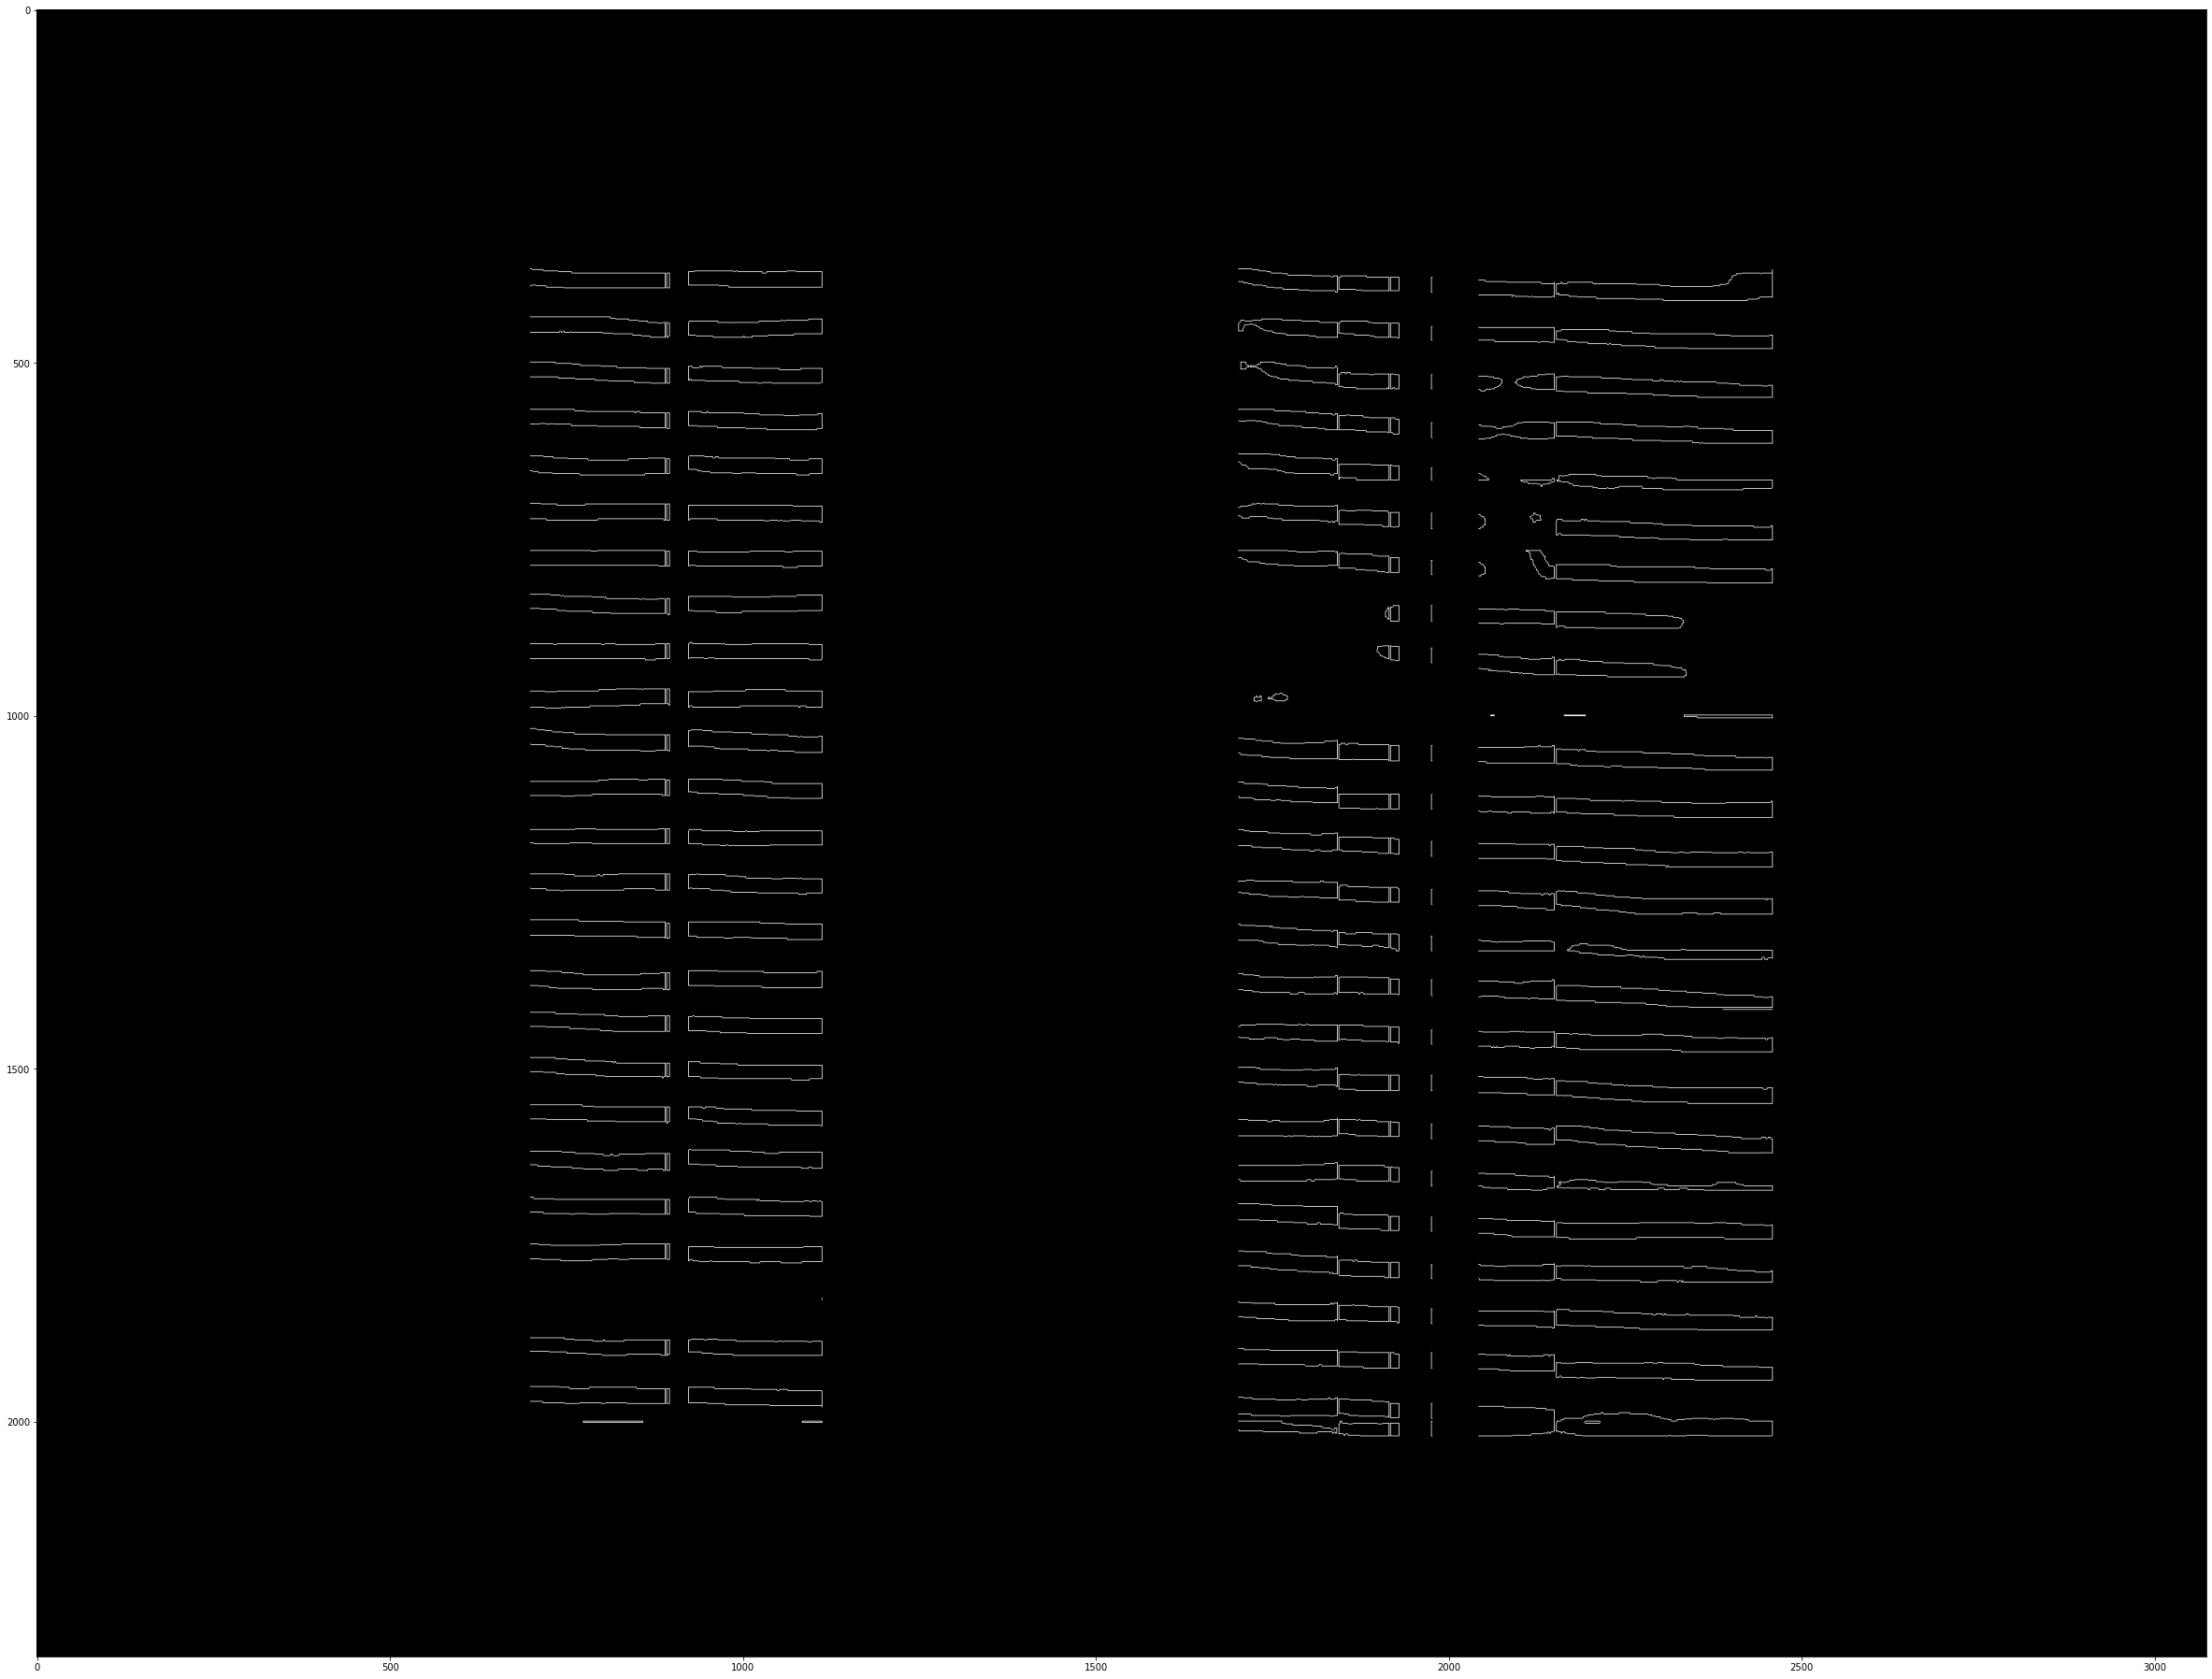

In [30]:
mask5 = mask4.copy()
mask5 = erase_lines_with_small_width(mask5, bbox_x1x2, 0.01, col_width_limit)
img_show_from_arr(mask4)
img_show_from_arr(mask5)

In [31]:
mask5_coords = next_neighbor_as_zero(mask5)

In [32]:
mask5_y_coords = [coord[0] for coord in mask5_coords]
len(mask5_y_coords)

56511

In [33]:
mask5_y_coords = np.array(mask5_y_coords)
mask5_unique_y_coords = np.unique(mask5_y_coords)
len(mask5_unique_y_coords)

1352

In [34]:
bbox_y_coords = []
bbox_y_coords.append(mask5_unique_y_coords[0])
for i in range(len(mask5_unique_y_coords)-1):
  if abs(mask5_unique_y_coords[i] - mask5_unique_y_coords[i+1]) > 2:
    bbox_y_coords.append(mask5_unique_y_coords[i])
    bbox_y_coords.append(mask5_unique_y_coords[i+1])
bbox_y_coords.append(mask5_unique_y_coords[-1])
bbox_y_coords = np.array(bbox_y_coords)
bbox_y_coords = np.unique(bbox_y_coords)
len(bbox_y_coords)

49

In [35]:
bbox_y1y2 = [(bbox_y_coords[i], bbox_y_coords[i+1]) for i in range(0, len(bbox_y_coords)-1, 2)]
bbox_y1y2

[(367, 412),
 (435, 480),
 (499, 549),
 (566, 614),
 (629, 680),
 (699, 751),
 (766, 812),
 (828, 876),
 (896, 945),
 (962, 989),
 (999, 1003),
 (1018, 1077),
 (1090, 1144),
 (1160, 1214),
 (1224, 1281),
 (1289, 1345),
 (1361, 1413),
 (1416, 1420),
 (1476, 1484),
 (1672, 1682),
 (1741, 1748),
 (1802, 1825),
 (1870, 1881),
 (1941, 1950)]

In [36]:
mask5_row_heights = get_row_heights(bbox_y1y2)
len(mask5_row_heights)

24

In [37]:
row_height_limit = np.mean(mask5_row_heights) * 0.7
row_height_limit

25.345833333333335

In [38]:
mask5_row_patches = []
for y1y2 in bbox_y1y2:
  if abs(y1y2[0] - y1y2[1]) > row_height_limit:
    mask5_row_patches.append(y1y2)
len(mask5_row_patches)

16

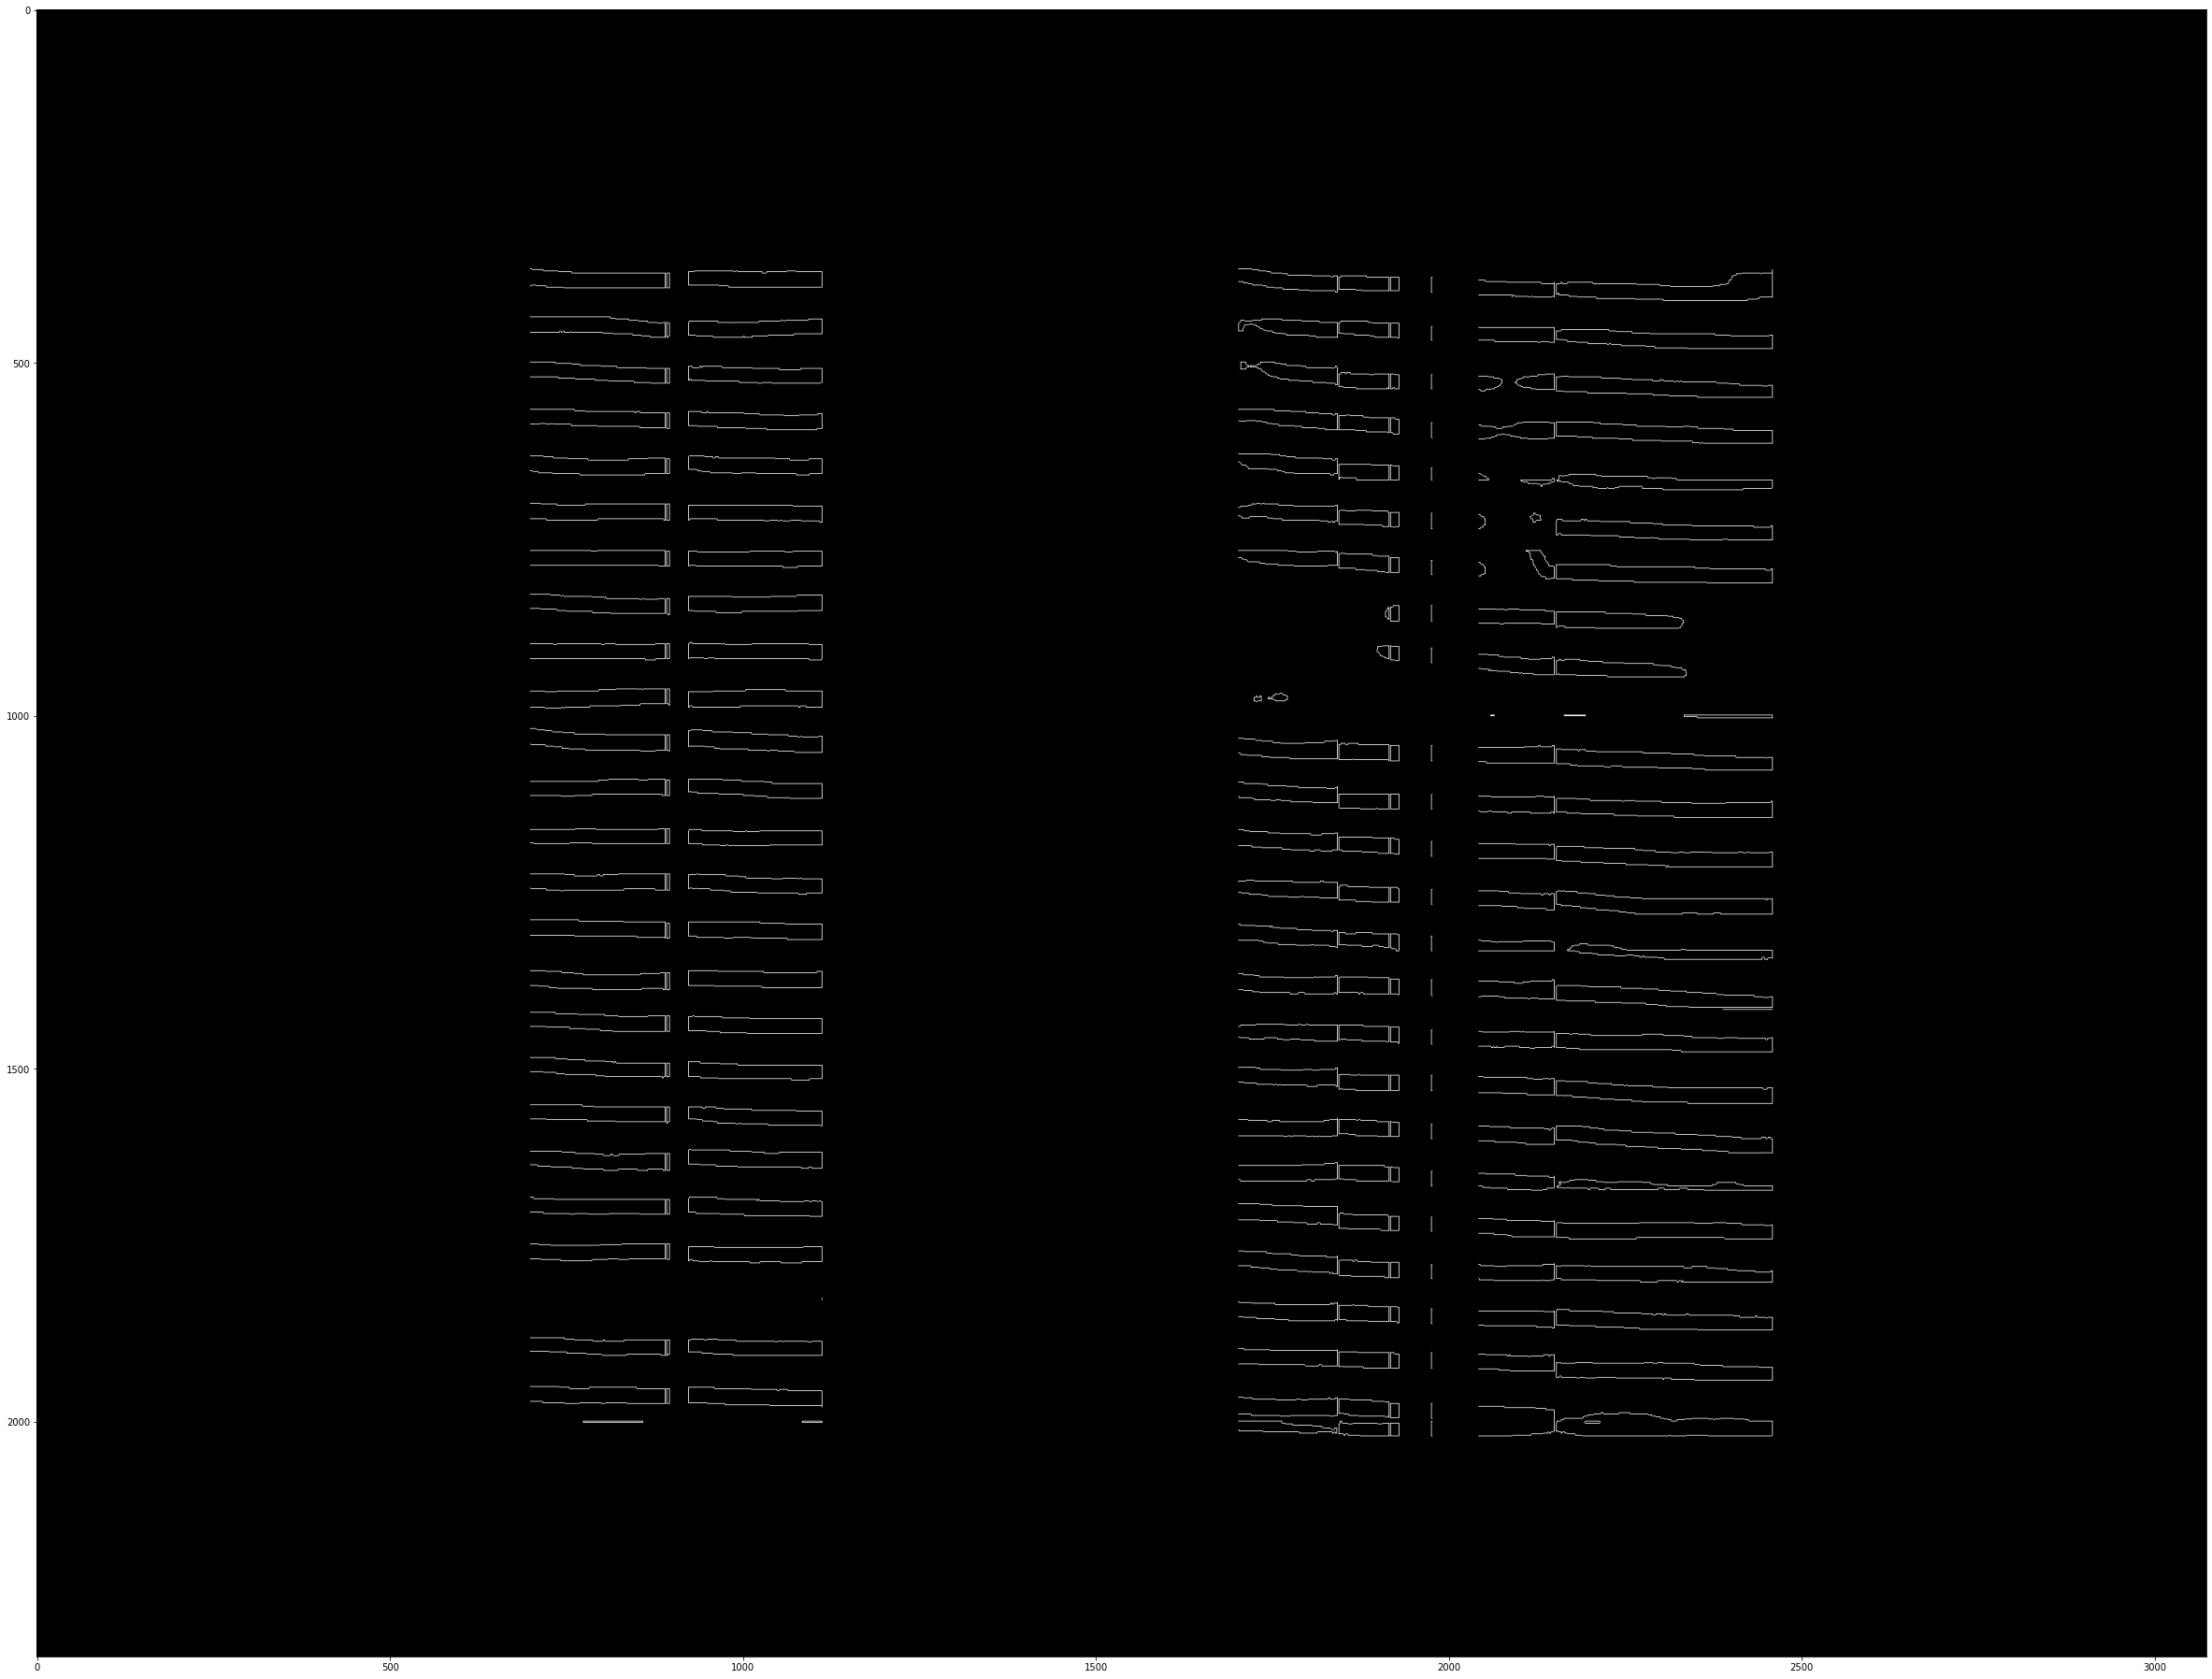

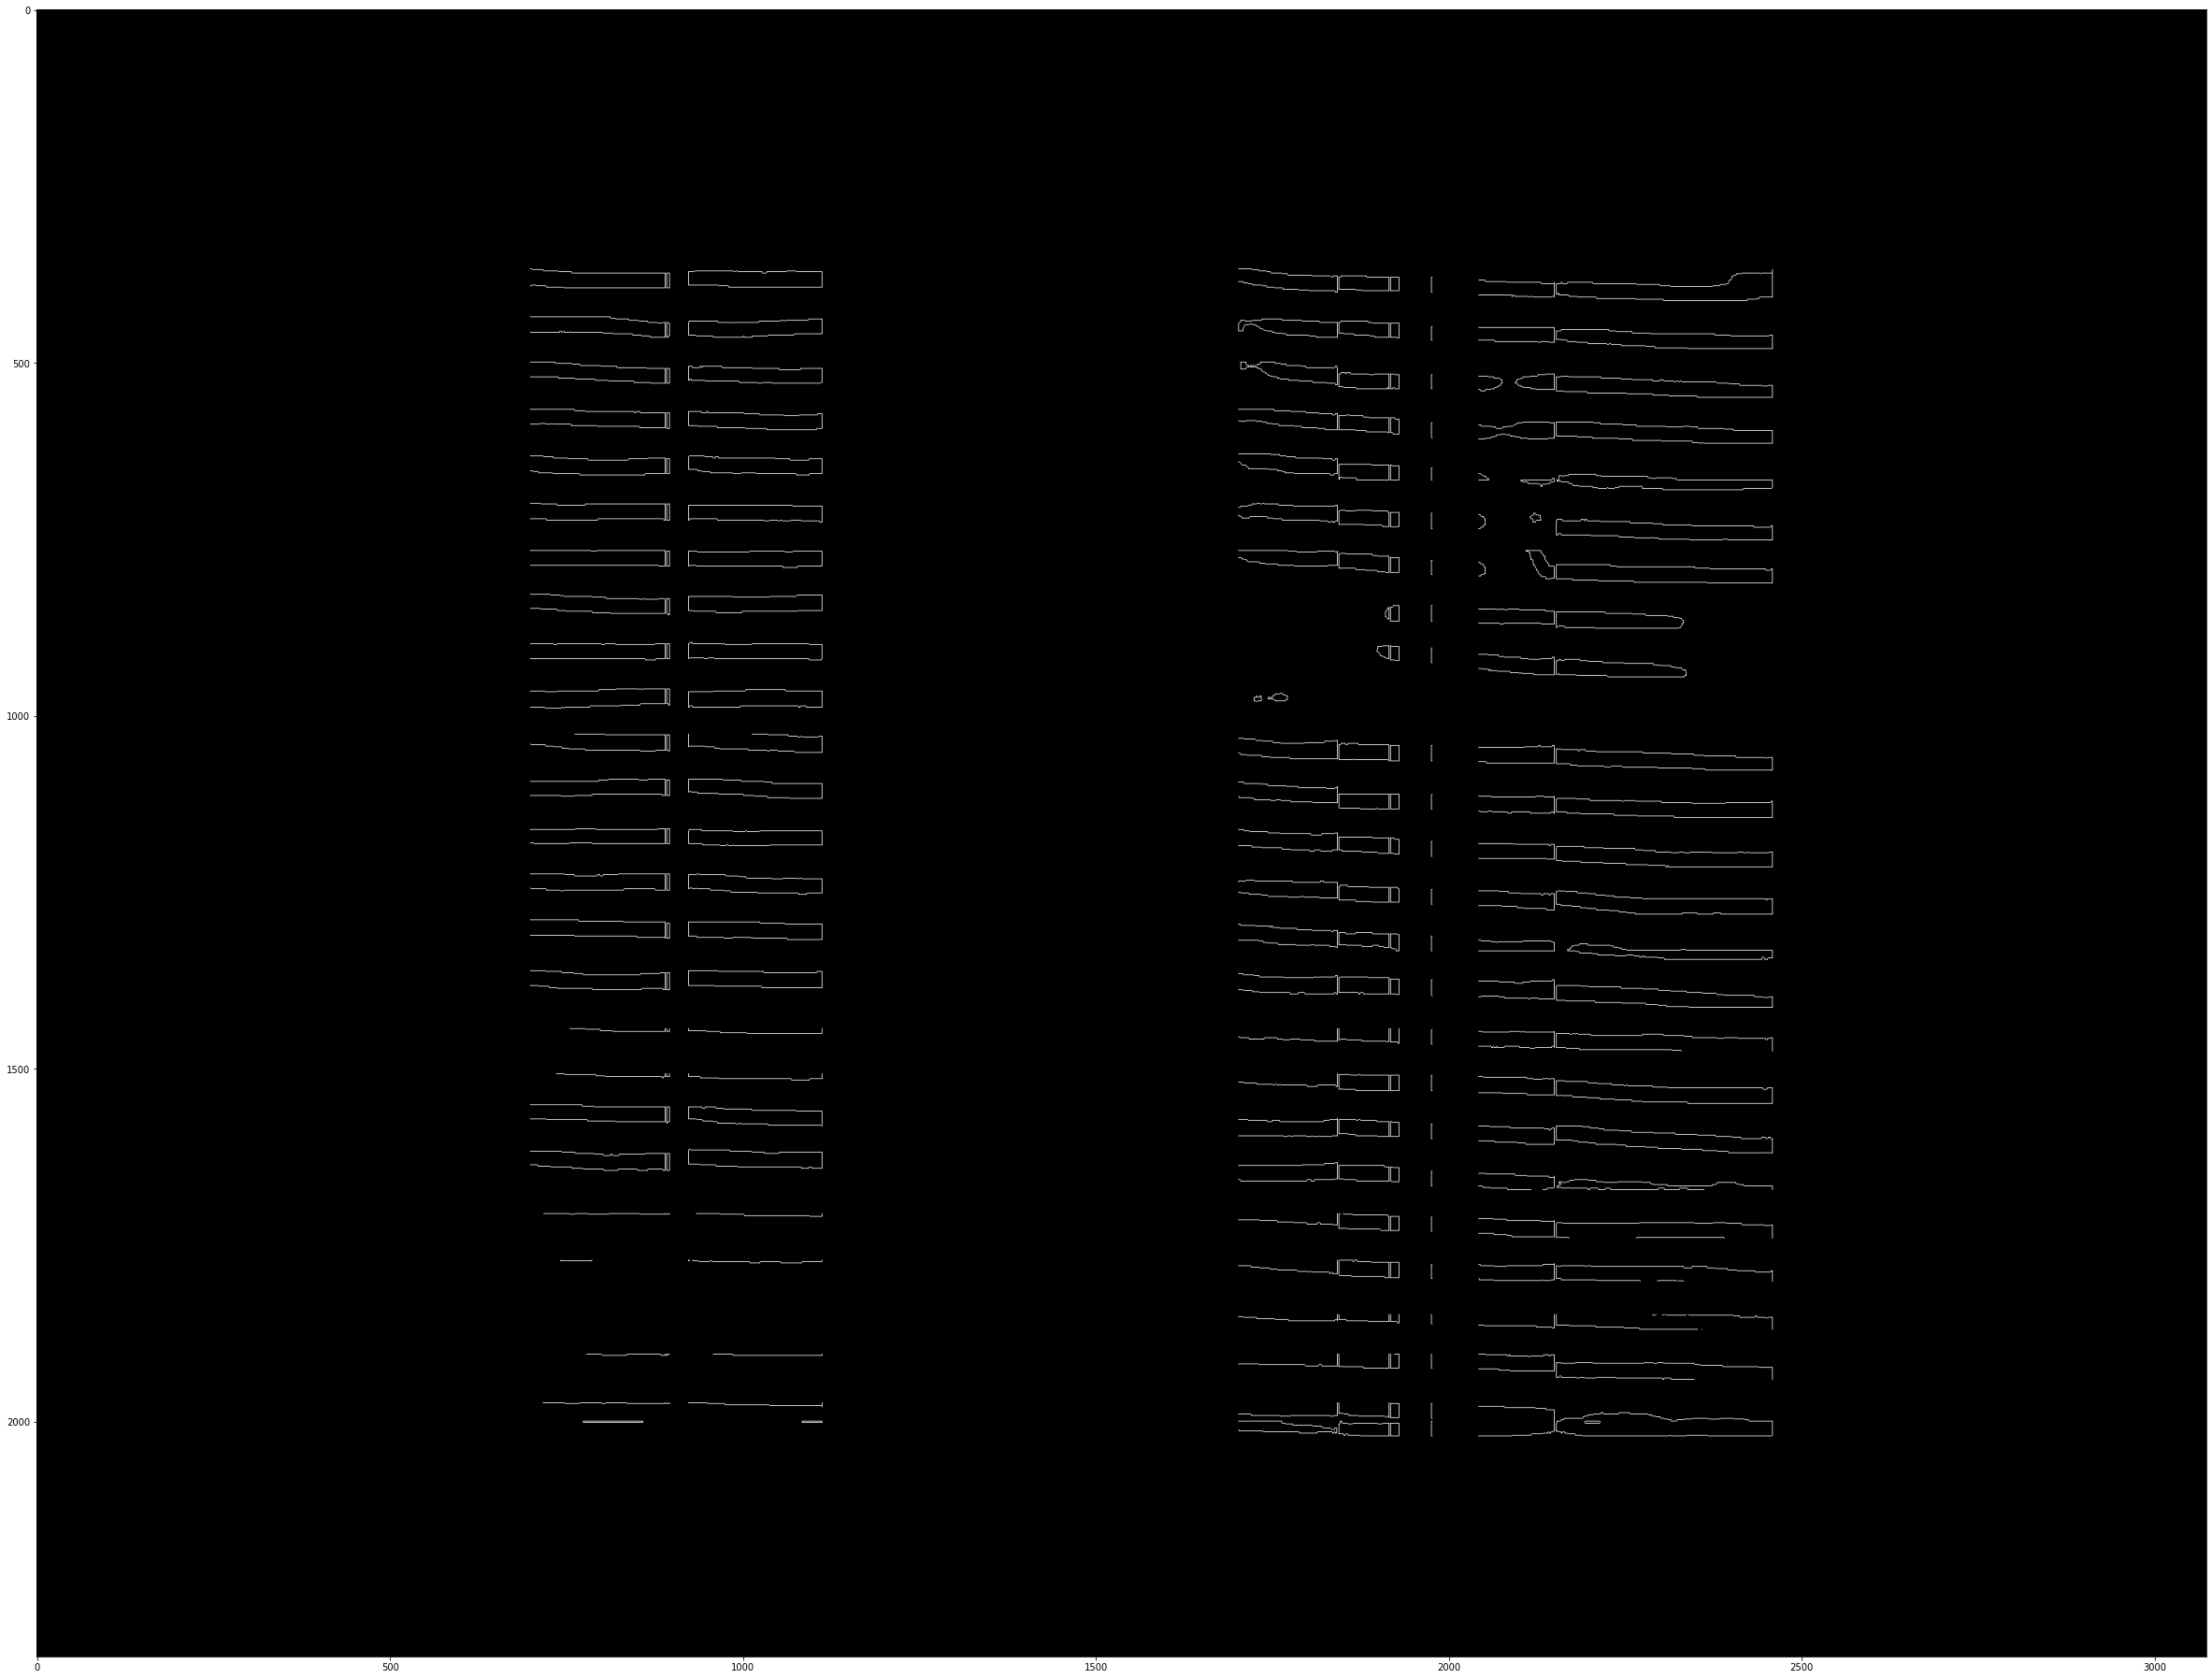

In [39]:
mask6 = mask5.copy()
mask6 = erase_lines_with_small_height(mask6, bbox_y1y2, 0.01, row_height_limit)
img_show_from_arr(mask5)
img_show_from_arr(mask6)

In [40]:
len(mask4_unique_x_coords)

1344

In [41]:
mask6_coords = next_neighbor_as_zero(mask6)
mask6_x_coords = [coord[1] for coord in mask6_coords]
mask6_x_coords = np.array(mask6_x_coords)
mask6_unique_x_coords = np.unique(mask6_x_coords)
len(mask6_unique_x_coords)

1030

In [42]:
mask6_bboxes = create_bbox_list(mask5_row_patches, mask6_unique_x_coords, 0.1, mask6_coords, 0.8)
len(mask6_bboxes[0])

Page type: two page image


29

In [ ]:
row_heights = np.array(get_row_heights(mask5_row_patches))
mean_row_heigth = np.mean(row_heights)
mean_row_heigth

45.36

In [ ]:
safety_gap_y = int(0.3 * mean_row_heigth)
col_widths = np.array(get_col_widths(bbox_x1x2))
mean_col_width = np.mean(col_widths)
mean_col_width

151.1

In [ ]:
safety_gap_x = int(0.1 * mean_col_width)

In [ ]:
x = mask6_bboxes[0:10]
x

([(617, 344, 1390, 393),
  (1657, 344, 2416, 393),
  (617, 412, 1390, 463),
  (1657, 412, 2416, 463),
  (678, 483, 1185, 530),
  (1657, 483, 2416, 530),
  (684, 547, 1185, 595),
  (1657, 547, 2416, 595),
  (617, 615, 1389, 660),
  (1657, 615, 2416, 660),
  (617, 683, 1390, 725),
  (1657, 683, 2416, 725),
  (617, 746, 1390, 794),
  (1657, 746, 2416, 794),
  (617, 811, 1390, 858),
  (1657, 811, 2416, 858),
  (617, 879, 1390, 921),
  (1663, 879, 2416, 921),
  (617, 940, 1389, 988),
  (1657, 940, 2416, 988),
  (617, 1001, 1383, 1053),
  (1657, 1001, 2416, 1053),
  (617, 1071, 1390, 1119),
  (1657, 1071, 2416, 1119),
  (617, 1135, 1390, 1187),
  (1657, 1135, 2416, 1187),
  (617, 1206, 1390, 1252),
  (1657, 1206, 2416, 1252),
  (617, 1276, 1390, 1318),
  (1657, 1276, 2416, 1318),
  (617, 1336, 1390, 1384),
  (1660, 1336, 2416, 1384),
  (617, 1408, 1390, 1450),
  (1661, 1408, 2416, 1450),
  (617, 1476, 1390, 1515),
  (1657, 1476, 2416, 1515),
  (617, 1543, 1390, 1579),
  (1668, 1543, 2416, 15

In [ ]:
y = mask6_bboxes[10:20]
y

()

In [ ]:
z = (x, y)
type(z)

tuple

In [ ]:
t = x
type(t)

tuple

In [ ]:
test_tup = (1,2,3)
type(test_tup)

tuple

In [ ]:
type(z) == type(test_tup)

True

In [ ]:
test_list = [1, 2, 3]
type(test_list)

list

In [ ]:
type(t) == type(test_list)

False

In [ ]:
def create_row_images2(bbox_list, img, safety_gap_x, safety_gap_y, unique_cols, line_gap_ratio):
  page_type = find_image_page_type(unique_cols, line_gap_ratio)
  h, w, d = img.shape
  if page_type == "two page image":
    page1 = []
    page2 = []
    mean_width = w // 2
    page_threshold = 0.7 * mean_width
    for i in range(len(bbox_list)):
        row = create_line_image_from_bbox(bbox_list[i], img, safety_gap_x, safety_gap_y)
        if bbox_list[i][0] < page_threshold:
          page1.append(row)
        else:
          page2.append(row)
    return (page1, page2)
  else:
    page = []
    for i in range(len(bbox_list)):
      row = create_line_image_from_bbox(bbox_list[i], img, safety_gap_x, safety_gap_y)
      page.append(row)
    return page

In [ ]:
image_rows = create_row_images(mask6_bboxes, img, safety_gap_x, safety_gap_y)
img_show_from_arr(img)
for row in image_rows:
  img_show_from_arr(row)

TypeError: ignored

In [ ]:
display_and_save_line_images(mask6_bboxes, img, safety_gap_x, safety_gap_y, save=True, img_path=img_path)